# Microbial scaling (data analysis)

In [1]:
import math
import numpy as np
from scipy import stats
#import sympy as smp
from pynverse import inversefunc
import pandas as pd
# from sympy.abc import t, a, b, c, d, e
import emcee
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns
import Amos_package as ap
from Amos_package import boxplot

In [2]:
df_microbial_growth = pd.read_csv('../data/modified_Susman18_physical_units.csv')
df_microbial_growth

div_and_fold  fold_growth  division_ratio  added_length  generationtime  \
0             NaN     1.170561             NaN      3.983777        0.750000   
1        1.009831     0.794984        0.456028      3.198324        0.500000   
2        0.862482     0.607893        0.469619      2.291172        0.416667   
3        1.426486     1.037370        0.505526      4.632409        0.833333   
4        0.729601     0.490156        0.446903      2.028413        0.333333   
..            ...          ...             ...           ...             ...   
247      0.940427     0.590789        0.520893      2.192641        0.416667   
248      0.928602     0.604227        0.507478      2.069835        0.500000   
249      1.568073     1.046815        0.550478      4.644408        0.750000   
250      0.809727     0.481681        0.500204      2.215210        0.333333   
251      0.860970     0.711011        0.422863      2.538870        0.500000   

     length_birth  length_final  growth_rate  lineage_ID  generation  \
0        1.791428      5.775204     1.560748        15.0         0.0   
1        2.633655      5.831979     1.589968        15.0         1.0   
2        2.738808      5.029980     1.458944        15.0         2.0   
3        2.542786      7.175195     1.244844        15.0         3.0   
4        3.206619      5.235033     1.470468        15.0         4.0   
..            ...           ...          ...         ...         ...   
247      2.722385      4.915026     1.417893        15.0       249.0   
248      2.494268      4.564104     1.208453        15.0       250.0   
249      2.512440      7.156848     1.395754        15.0       251.0   
250      3.579885      5.795095     1.445043        15.0       252.0   
251      2.450531      4.989402     1.422022        15.0       253.0   

     start_time    end_time  
0      0.250000    1.000000  
1      1.083333    1.583333  
2      1.666667    2.083333  
3      2.166667    3.000000  
4      3.083333    3.416667  
..          ...         ...  
247  150.583333  151.000000  
248  151.083333  151.583333  
249  151.666667  152.416667  
250  152.500000  152.833333  
251  152.916667  153.416667  

[252 rows x 12 columns]

In [3]:
print(df_microbial_growth['lineage_ID'].nunique()) 

# if 1, it means there is only one cell

1


## Estimate the pdf of $\omega_1$ and $\text{f}$ from real data

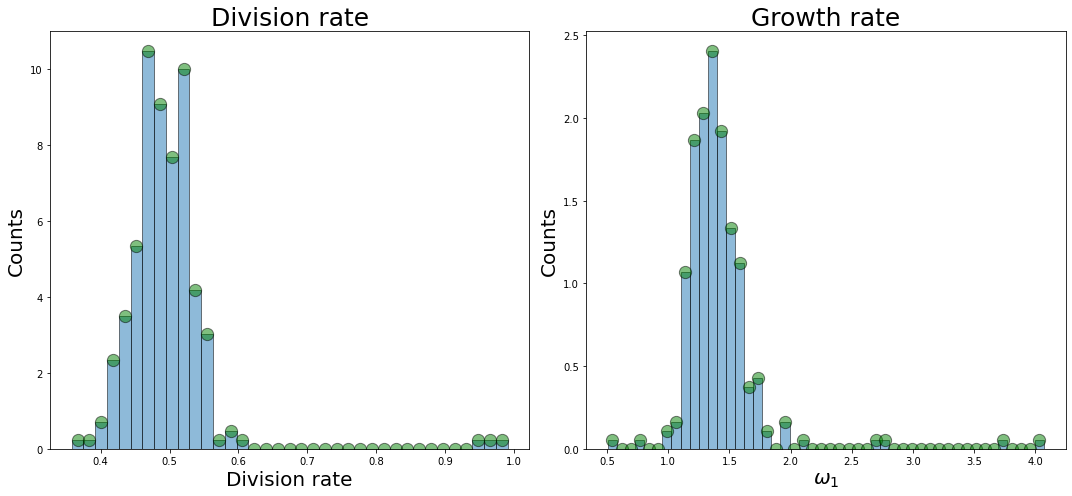

In [4]:
fig, ax = plt.subplots(1,2 , figsize=(15, 7))
hist_val_div = ax[0].hist(df_microbial_growth['division_ratio'], bins='fd', edgecolor='black', alpha=0.5, density=True)
div_centers = (hist_val_div[1][:-1] + hist_val_div[1][1:]) / 2
ax[0].scatter(div_centers, hist_val_div[0], s=150, color='green', alpha=0.5, edgecolor='black')
ax[0].set_xlabel('Division rate', fontsize=20)
ax[0].set_ylabel('Counts', fontsize=20)
ax[0].set_title('Division rate', fontsize=25)
hist_val_grow = ax[1].hist(df_microbial_growth['growth_rate'], bins='fd', edgecolor='black', alpha=0.5, density=True)
grow_centers = (hist_val_grow[1][:-1] + hist_val_grow[1][1:]) / 2
ax[1].scatter(grow_centers, hist_val_grow[0], s=150, color='green', alpha=0.5, edgecolor='black')
ax[1].set_xlabel('$\\omega_1$', fontsize=20)
ax[1].set_ylabel('Counts', fontsize=20)
ax[1].set_title('Growth rate', fontsize=25)
fig.tight_layout()


First, we fit the distribution of division rates with a beta function.

In [5]:
def fit_beta(x, a, b):
    return(scp.stats.beta.pdf(x, a=a,b=b))

popt, pcov = scp.optimize.curve_fit(fit_beta, xdata=div_centers, ydata = hist_val_div[0])


The parameters found for the beta distribution are:
a = 76.6 +- 6.0
b = 79.6 +- 6.2


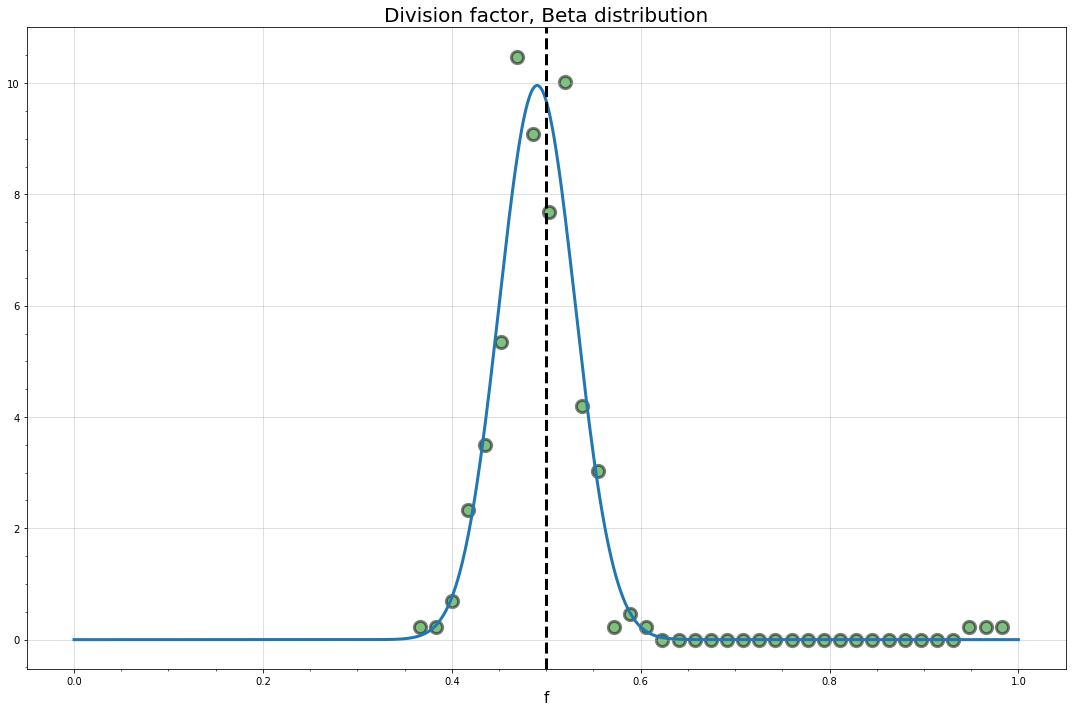

In [6]:
x_axis = np.linspace(0,1,1000)
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.plot(x_axis, scp.stats.beta.pdf(x_axis, a=popt[0],b=popt[1]), linewidth=3)
ax.scatter(div_centers, hist_val_div[0], linewidth=3, s=150, color='green', edgecolor = 'black', alpha=0.5)
ax.axvline(0.5, color='black', linestyle='dashed',  linewidth=3) 
ax.grid(alpha=0.5)
ax.set_title('Division factor, Beta distribution', fontsize=20)
ax.set_xlabel('f', fontsize=15)
ax.minorticks_on()
fig.tight_layout()

a_beta = popt[0]
b_beta = popt[1]
print('The parameters found for the beta distribution are:')
print('a =', np.round(a_beta,1),'+-', np.round(np.sqrt(pcov)[0,0],1))
print('b =', np.round(b_beta,1),'+-', np.round(np.sqrt(pcov)[1,1],1))



Notice that the values of the parameters $a$ and $b$ of the Beta distribution are very close to each other and as expected the distribution is almost centered around $0.5$.

We repeat the same analysis for the growth rates, in this case fitting the real data with a Gamma distribution.

In [7]:
def fit_gamma(x, a, teta):
    return(scp.stats.gamma.pdf(x, a=a, scale=teta))

popt, pcov = scp.optimize.curve_fit(fit_gamma, xdata=grow_centers, ydata = hist_val_grow[0])


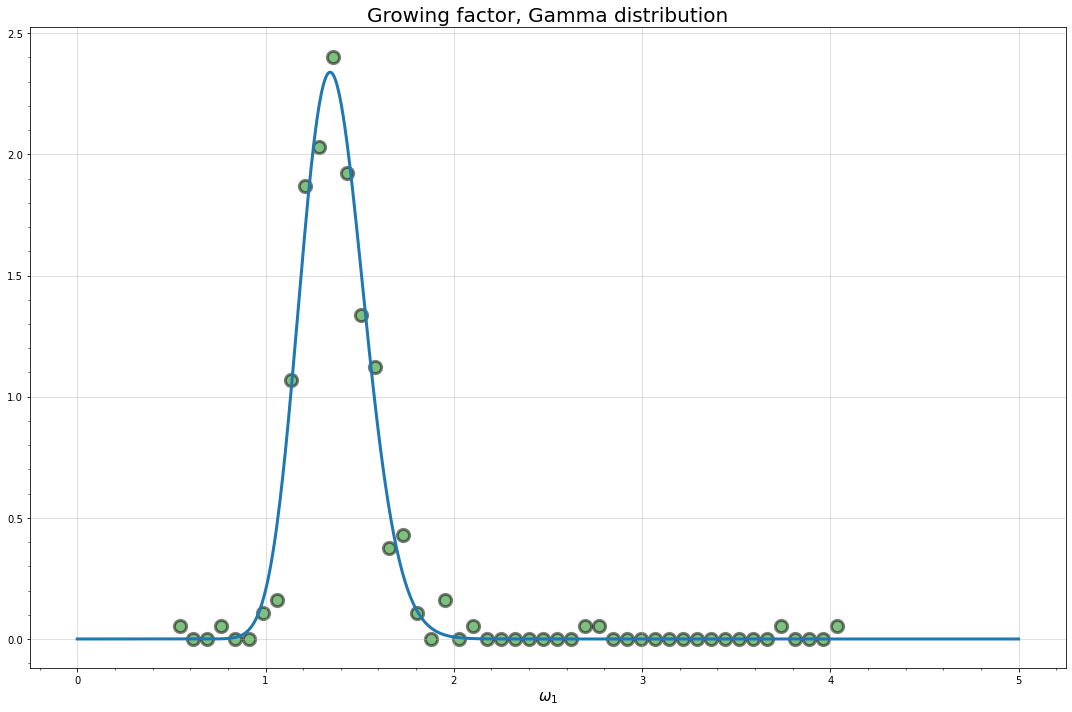

In [8]:
x_axis = np.linspace(0,5,1000)
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.plot(x_axis, scp.stats.gamma.pdf(x_axis, a=popt[0], scale=popt[1]), linewidth=3)
ax.scatter(grow_centers, hist_val_grow[0], linewidth=3, s=150, color='green', edgecolor = 'black', alpha=0.5)
ax.grid(alpha=0.5)
ax.set_title('Growing factor, Gamma distribution', fontsize=20)
ax.set_xlabel('$\omega_1$', fontsize=15)
ax.minorticks_on()
fig.tight_layout()




In [9]:
a_gamma = popt[0]
teta_gamma = popt[1]

print('The parameters found for the gamma distribution are:')
print('a =', np.round(a_gamma,1),'+-', np.round(np.sqrt(pcov[0,0]),1))
print('b =', np.round(teta_gamma,3),'+-', np.round(np.sqrt(pcov[1,1]),3))

The parameters found for the gamma distribution are:
a = 63.2 +- 2.7
b = 0.022 +- 0.001


In [10]:
# draw some values of s using a uniform distribution between 0 and 1 

np.random.seed(seed=123)

size = len(df_microbial_growth['generationtime']) # length of the time series (= number of divisions)
s_drawn = np.random.uniform(low=0, high = 1, size = size)
print('Some drawn values of s:', s_drawn[:5])

Some drawn values of s: [0.69646919 0.28613933 0.22685145 0.55131477 0.71946897]


## Prior distributions

In [11]:
def prior_omega2(omega2):
    return(stats.lognorm.pdf(omega2, s=np.sqrt(1/3 - np.log(0.9)), loc=0, scale=np.exp(1/3 )))

def prior_mu(mu):
    return(stats.beta.pdf(mu, a=2, b=5))

def prior_nu(nu):
    return(stats.lognorm.pdf(nu, s=1/3, loc=0.1, scale=np.exp(1/9)))

def prior_omega1(omega1):
    return(scp.stats.gamma.pdf(omega1, a=a_gamma, scale=teta_gamma)) # use the values found above

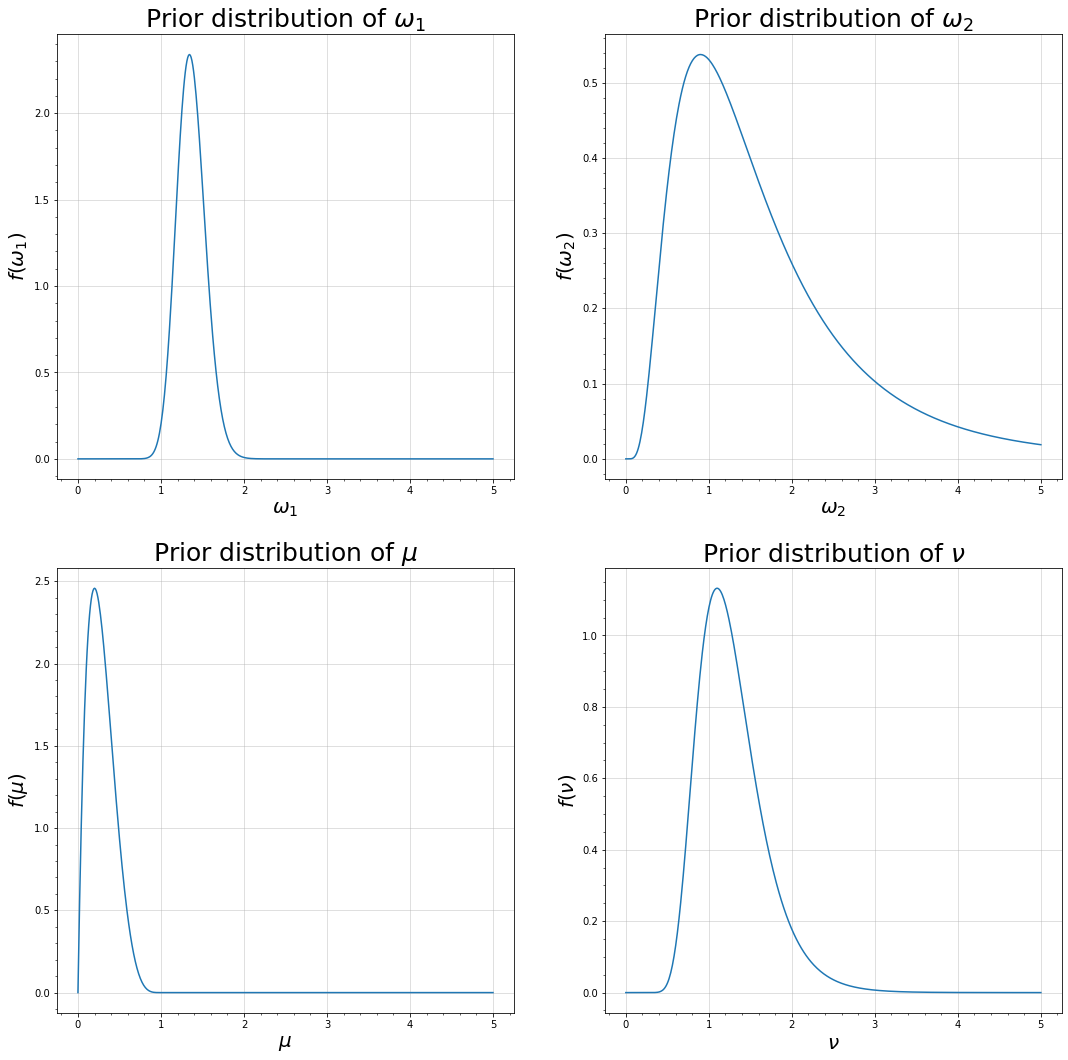

In [12]:
x = np.linspace(0, 5, 500)

_, ax = plt.subplots(2, 2, figsize=(18, 18))
ax[0, 0].plot(x, prior_omega1(x))
ax[0, 1].plot(x, prior_omega2(x)) 
ax[1, 0].plot(x, prior_mu(x)) 
ax[1, 1].plot(x, prior_nu(x))

param_str = [['$\omega_1$', '$\omega_2$'], ['$\mu$', '$\\nu$']]

for i in range(2):
    for j in range(2):
        ax[i, j].set_title('Prior distribution of ' + param_str[i][j], fontsize=25)
        ax[i, j].set_xlabel(param_str[i][j], fontsize=20)
        ax[i, j].set_ylabel('$f($'+param_str[i][j]+'$)$', fontsize=20)
        ax[i, j].minorticks_on()
        ax[i, j].grid(alpha=0.5)

## Definitions

In [13]:
'''
MCMC chain, pairplot
'''
def pairplot(chain):
    chain_df = pd.DataFrame(chain, columns=['omega1', 'omega2', 'mu', 'nu'])
    g = sns.pairplot(chain_df, diag_kind="hist", corner=True, plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.3}, diag_kws={'color':'green', 'alpha':0.5})
    g.map_lower(sns.kdeplot, levels=5, color="firebrick", linewidth=2)
    axes = g.axes.ravel()
    axes_2 = []
    for ax in axes:
        if ax != None:
            axes_2.append(ax)
    axes_2
    axes_2[0].vlines(x=1, ymin=0, ymax=1, color='navy')
    axes_2[1].vlines(x=1, ymin=0, ymax=np.max(chain[:,1]), linewidth=2, color='navy')
    axes_2[2].set_ylim(bottom=0)
    axes_2[4].set_ylim(bottom=0)
    axes_2[6].set_ylim(bottom=0)
    axes_2[0].set_ylim(bottom=0)

    axes_2[1].hlines(y=0.9, xmin=0, xmax=2, linewidth=2, color='navy')
    axes_2[2].vlines(x=0.9, ymin=0, ymax=6, linewidth=2, color='navy')
    axes_2[3].vlines(x=1, ymin=-0.1, ymax=np.max(chain[:,2])+0.1, linewidth=2, color='navy')
    axes_2[3].hlines(y=0.1, xmin=0, xmax=2, linewidth=2, color='navy')

    axes_2[4].vlines(x=0.9, ymin=-0.1, ymax=np.max(chain[:,2])+0.1, linewidth=2, color='navy')
    axes_2[4].set_ylim(bottom=-0.1, top=0.6)
    axes_2[4].hlines(y=0.1, xmin=0, xmax=np.max(chain[:,1]), linewidth=2, color='navy')

    axes_2[5].vlines(x=0.1, ymin=-0.1, ymax=0.5, linewidth=2, color='navy')
    axes_2[6].vlines(x=1, ymin=0, ymax=np.max(chain[:,0]), linewidth=2, color='navy')
    axes_2[6].hlines(y=1, xmin=0, xmax=2, linewidth=2, color='navy')

    axes_2[6].set_xlim(left=0)
    axes_2[7].vlines(x=0.9, ymin=0, ymax=np.max(chain[:,1]), linewidth=2, color='navy')
    axes_2[7].hlines(y=1, xmin=0, xmax=np.max(chain[:,1]), linewidth=2, color='navy')
    axes_2[8].vlines(x=0.1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')

    axes_2[8].hlines(y=1, xmin=-0.1, xmax=np.max(chain[:,2]), linewidth=2, color='navy')
    axes_2[8].set_xlim(left=-0.1)
    axes_2[9].vlines(x=1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')
    return g

In [14]:
'''
Simulation of the time series 
> The division rates are sampled from the inferred beta distribution 
'''
def sim_t_draw(CDF, x_function, points_per_evolution, xb, model, pars=(1,0.9,0.1,1,1)):

    '''
    Find tau numerically
    '''
    def draw_tau_numerical(K, parameters=pars):
        (omega1, omega2, mu, nu, xb) = parameters
        if model =='s':
            t0 = max([0,0])
        elif model == '1':
            t0 = max([0, (1.0/omega1) * np.log(mu/xb)])
        elif model == '2':
            t0 = max([0, (1.0/omega1) * np.log(1 + (mu/xb))])
        else:
            raise Exception("Model has to be either 's', '1', or '2' ")
            
        t_max = 8/omega1 # approx. 5 tau to avoid roundoff error
        tau = inversefunc(CDF, args=(parameters,), y_values=K,  domain=[t0, t_max], open_domain=True)
        
        
        return tau

    t = 0


    all_times = np.zeros(points_per_evolution*size)
    cell_sizes = np.zeros(points_per_evolution*size)
    sim_t_starting = []

    for i in range(size): 
        parameters = (omg1[i],0.9,0.1,1,xb) # omega1, omega2, mu, nu, xb
        tau = draw_tau_numerical(s_drawn[i], parameters=parameters)
        sim_t_starting.append(tau)

        # evolution
        times = np.linspace(0, tau, points_per_evolution)
        xt = x_function(times, parameters)
        
        # store times and sizes
        all_times[i*points_per_evolution : (i+1)*points_per_evolution] = np.linspace(t, t+tau, points_per_evolution)
        cell_sizes[i*points_per_evolution : (i+1)*points_per_evolution] = xt

        # update the initial time and the starting size
        xb = xt[-1]*frac[i]
        t = t+tau

    sim_t_starting = np.array(sim_t_starting)

    return sim_t_starting, all_times, cell_sizes


In [15]:
'''
Time series plot
'''
def plot_evol(all_times, cell_sizes):
    fig, ax = plt.subplots(1,1 , figsize=(25, 10))
    ax.plot(all_times, cell_sizes, linewidth=3, color='C0')
    ax.set_title('Cell size evolution', fontsize=25)
    ax.set_xlabel('t', fontsize = 20)
    ax.set_ylabel('Cell size', fontsize=20)
    ax.minorticks_on()
    ax.grid(alpha=0.5)
    return fig, ax


In [16]:
'''
Log unnormalized posterior, for emcee
'''
def j_log_unnorm_posterior_emcee(params, y_times, PDF):
    
    try:
        omega_1, omega_2, u, nu = np.array(params)
        ret = np.sum(np.log(PDF(y_times, pars=(omega_1, omega_2, u, nu, 1)))) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu)) + np.log(prior_omega2(omega_2))
    
        if ret*0 ==0:
            return(ret)
        else:return(-np.inf)
    
        
        #return(log_likelihood(y_times, pars=(1, omega_2, u, 1, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1))
    except:
        #omega_1, omega_2, u = np.array([0.00001, 0.000001, 0.00001])
        return(-np.inf)

In [17]:
'''
Plot of the posterior distribution of simulated data
'''
def plot_func_sim(chain, true_value, parameter, x_median=-0.1, y_median=2.26, x_max=0.02, \
            y_max=2.2, true_x = 0.08, true_y = 1.8):
    if parameter == 'omega_1':
        index = 0
    elif parameter == 'omega_2':
        index = 1
    elif parameter == 'mu':
        index = 2
    elif parameter == 'nu':
        index = 3
    else:
        return 'The parameter should be chose between [omega_1, omega_2, mu, nu]'

    fig, ax = plt.subplots(1,1 , figsize=(15, 10))
    res_omega_1 = ax.hist(chain[:,index], bins='fd', edgecolor='black', alpha=0.5, density=True)

    counts_omega_1 = res_omega_1[0]
    edges_omega_1 = res_omega_1[1]
    patches_omega_1 = res_omega_1[2]
    centers_omega_1 = (edges_omega_1[:-1] + edges_omega_1[1:]) / 2

    tmp = np.cumsum(np.diff(edges_omega_1)*counts_omega_1)

    max_index = np.argmax(counts_omega_1)
    max_omega_1 = (edges_omega_1[max_index] + edges_omega_1[max_index + 1])/2
    median_omega_1 = (edges_omega_1[len(tmp[tmp<0.5])+1] + edges_omega_1[len(tmp[tmp<0.5])+2])/2
    print('Median value of omega_1:', round(median_omega_1, 4))
    for i in range(len(tmp[tmp<0.025])):
        patches_omega_1[i].set_facecolor('green')
    for i in range(len(tmp[tmp<0.975]), len(tmp)):
        patches_omega_1[i].set_facecolor('green')

    ax.minorticks_on()
    ax.set_ylabel('Counts', fontsize=15)
    ax.set_xlabel(f'$\\{parameter}$', fontsize=15)
    ax.set_title(f'$\\{parameter}$ posterior', fontsize=20)
    ax.axvline(median_omega_1, color='crimson', linestyle='dashed',  linewidth=3, label='median $\omega_1$ = ' + str(round(median_omega_1, 4)))
    ax.axvline(max_omega_1, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\omega_1$ = ' + str(round(max_omega_1, 4)))
    ax.axvline(true_value, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\omega_1$ = 1')

    ax.text(median_omega_1+x_median, y_median, f'median $\{parameter}$' , color='crimson', fontsize=17)
    ax.text(max_omega_1+x_max, y_max, f'max $\{parameter}$', color='darkgreen', fontsize=17)
    ax.text(true_value - true_x, true_y, f'true $\{parameter}$', color='blueviolet', fontsize=17)


    print('Max value of omega_1:', round(max_omega_1, 4))


    ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')

    return fig, ax, centers_omega_1, counts_omega_1

In [18]:
'''
Plot of the posterior distribution of real data
'''
def plot_func_real(chain, parameter, x_median=-0.1, y_median=2.26, x_max=0.02, \
            y_max=2.2):
    if parameter == 'omega_1':
        index = 0
    elif parameter == 'omega_2':
        index = 1
    elif parameter == 'mu':
        index = 2
    elif parameter == 'nu':
        index = 3
    else:
        return 'The parameter should be chose between [omega_1, omega_2, mu, nu]'

    fig, ax = plt.subplots(1,1 , figsize=(15, 10))
    res_omega_1 = ax.hist(chain[:,index], bins='fd', edgecolor='black', alpha=0.5, density=True)

    counts_omega_1 = res_omega_1[0]
    edges_omega_1 = res_omega_1[1]
    patches_omega_1 = res_omega_1[2]
    centers_omega_1 = (edges_omega_1[:-1] + edges_omega_1[1:]) / 2

    tmp = np.cumsum(np.diff(edges_omega_1)*counts_omega_1)

    max_index = np.argmax(counts_omega_1)
    max_omega_1 = (edges_omega_1[max_index] + edges_omega_1[max_index + 1])/2
    median_omega_1 = (edges_omega_1[len(tmp[tmp<0.5])+1] + edges_omega_1[len(tmp[tmp<0.5])+2])/2
    print('Median value of omega_1:', round(median_omega_1, 4))
    for i in range(len(tmp[tmp<0.025])):
        patches_omega_1[i].set_facecolor('green')
    for i in range(len(tmp[tmp<0.975]), len(tmp)):
        patches_omega_1[i].set_facecolor('green')

    ax.minorticks_on()
    ax.set_ylabel('Counts', fontsize=15)
    ax.set_xlabel(f'$\\{parameter}$', fontsize=15)
    ax.set_title(f'$\\{parameter}$ posterior', fontsize=20)
    ax.axvline(median_omega_1, color='crimson', linestyle='dashed',  linewidth=3, label='median $\omega_1$ = ' + str(round(median_omega_1, 4)))
    ax.axvline(max_omega_1, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\omega_1$ = ' + str(round(max_omega_1, 4)))
    

    ax.text(median_omega_1+x_median, y_median, f'median $\{parameter}$' , color='crimson', fontsize=17)
    ax.text(max_omega_1+x_max, y_max, f'max $\{parameter}$', color='darkgreen', fontsize=17)
    


    print('Max value of omega_1:', round(max_omega_1, 4))


    ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')

    return fig, ax, centers_omega_1, counts_omega_1

## Emcee, n_walkers and p0

In [19]:
n_walkers = 20

In [20]:
p0_u = np.random.uniform(low=0.01, high=0.15, size=n_walkers).reshape(-1, 1)
p0_omega_2 =np.random.uniform(low=0.5, high=1.2, size=n_walkers).reshape(-1, 1)

p0_omega_1 = np.random.gamma(shape=a_gamma, scale=teta_gamma, size=n_walkers).reshape(-1, 1)

p0_omega_1[p0_omega_1 > 1.7] = a_gamma*teta_gamma
p0_omega_1[p0_omega_1 < 1] = a_gamma*teta_gamma

p0_nu = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)

p0 = np.hstack([p0_omega_1, p0_omega_2, p0_u, p0_nu])

In [21]:
# number of time points between 2 divisions
points_per_evolution=100     

# sample omega 1 and frac from the distributions
omg1 = np.random.gamma(shape=a_gamma, scale=teta_gamma, size=size)
frac = np.random.beta(a_beta, b_beta, size=size)

# get size at birth from real data
xb_realdata = df_microbial_growth['length_birth'][0]

# Simulated data, using parameters inferred from real data

## Starting model

In [22]:
'''
Cell size evolution x(t)
'''
def x_function_start(t, pars=(1,0.9,0.1,1,xb_realdata)):
    (omega1, omega2, mu, nu, xb) = pars

    x = (xb+mu/omega1)*np.exp(omega1*t)-mu/omega1
    return x
    
'''
Hazard rate function h(t)
'''
def h_start(t, pars=(1,0.9,0.1,1,xb_realdata)):
    (omega1, omega2, mu, nu, xb) = pars

    h = omega2*(1+x_function_start(t, pars)/nu)
    return h

'''
Survival function s(t)
'''
def CDF_start(t, pars=(1,0.9,0.1,1,xb_realdata)):
    (omega1, omega2, mu, nu, xb) = pars

    s = np.exp(omega2*t*(mu/nu - 1) + (omega1/omega2)*((mu + xb)/nu)*(1-np.exp(omega1*t)))
    return s

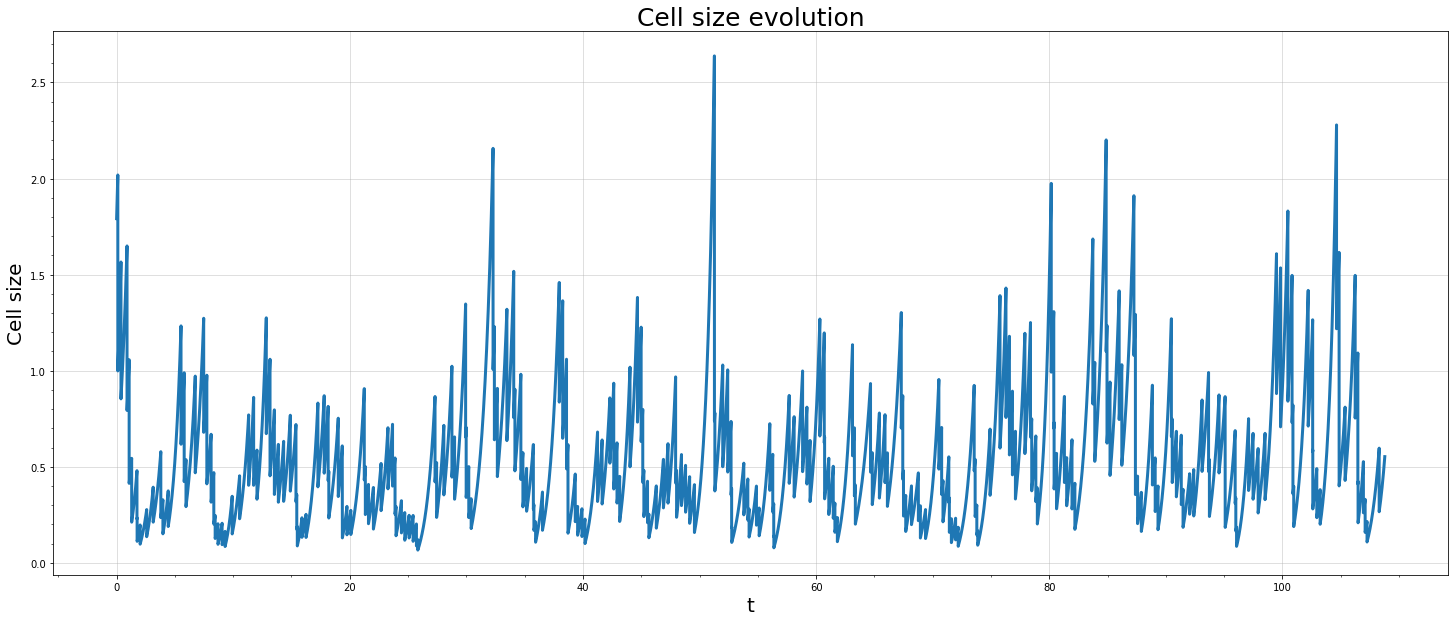

In [24]:
# simulate the time series
sim_t_starting, all_times_starting, cell_sizes_starting = sim_t_draw(CDF=CDF_start, x_function=x_function_start, points_per_evolution=points_per_evolution, xb=xb_realdata, model = 's')
fig, ax = plot_evol(all_times=all_times_starting, cell_sizes=cell_sizes_starting)


In [25]:
def PDF_start(t,  pars=(1,0.9,0.1,1,xb_realdata)):
    (omega1, omega2, mu, nu, xb) = pars

    unnormalized = h_start(t, pars)*CDF_start(t, pars)
    idx = np.argsort(t)
    normalization = np.trapz(x=t[idx], y=unnormalized[idx])

    return(unnormalized/normalization)

In [26]:
# emcee
# n_walkers = 20

sampler = emcee.EnsembleSampler(n_walkers, 4, j_log_unnorm_posterior_emcee, kwargs={'y_times':sim_t_starting, 'PDF':PDF_start}, a=2)
'''
3   is the number of dimensions in the parameter space
a=2 is the proposal scale parameter. (default: 2.0)
'''

pos, prob, state = sampler.run_mcmc(p0, 200)
sampler.reset()
sampler.run_mcmc(pos, 5000, rstate0=state)

chain_start_sim = sampler.get_chain(flat=True)

'''
p0   is the initial state
5000 is the number of steps to run
'''

<ipython-input-16-2b5923c49bae>:8: RuntimeWarning: divide by zero encountered in log
  ret = np.sum(np.log(PDF(y_times, pars=(omega_1, omega_2, u, nu, 1)))) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu)) + np.log(prior_omega2(omega_2))
<ipython-input-16-2b5923c49bae>:10: RuntimeWarning: invalid value encountered in double_scalars
  if ret*0 ==0:
<ipython-input-22-3a7a7f52ae10>:25: RuntimeWarning: overflow encountered in exp
  s = np.exp(omega2*t*(mu/nu - 1) + (omega1/omega2)*((mu + xb)/nu)*(1-np.exp(omega1*t)))
<ipython-input-25-34acce47cce7>:8: RuntimeWarning: invalid value encountered in true_divide
  return(unnormalized/normalization)
<ipython-input-16-2b5923c49bae>:8: RuntimeWarning: invalid value encountered in log
  ret = np.sum(np.log(PDF(y_times, pars=(omega_1, omega_2, u, nu, 1)))) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu)) + np.log(prior_omega2(omega_2))


'\np0   is the initial state\n5000 is the number of steps to run\n'

### Plot posterior distributions and chains

Median value of omega_1: 1.1519
Max value of omega_1: 1.1623


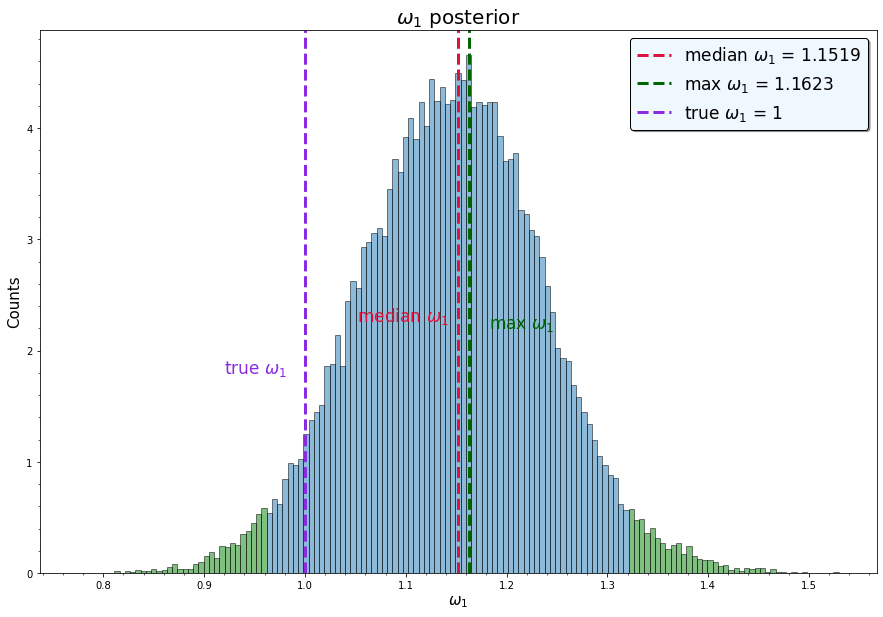

In [27]:
fig, ax, centers_omega1_s_r, counts_omega1_s_r = plot_func_sim(chain= chain_start_sim, true_value=1, parameter='omega_1')

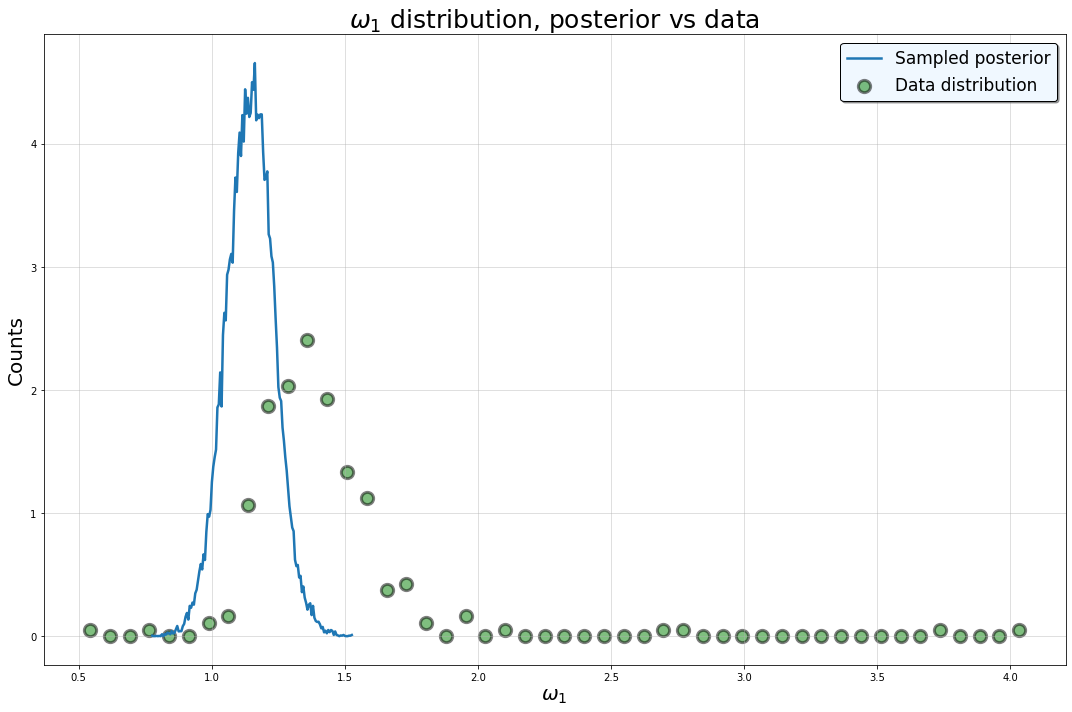

In [28]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.plot(centers_omega1_s_r, counts_omega1_s_r, label = 'Sampled posterior', linewidth=2.5)
ax.scatter(grow_centers, hist_val_grow[0], linewidth=3, s=150, color='green', edgecolor = 'black', alpha=0.5, label='Data distribution')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
ax.grid(alpha=0.5)
ax.set_xlabel('$\omega_1$', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.set_title('$\omega_1$ distribution, posterior vs data', fontsize = 25)
fig.tight_layout()

Median value of omega_1: 1.8675
Max value of omega_1: 1.8324


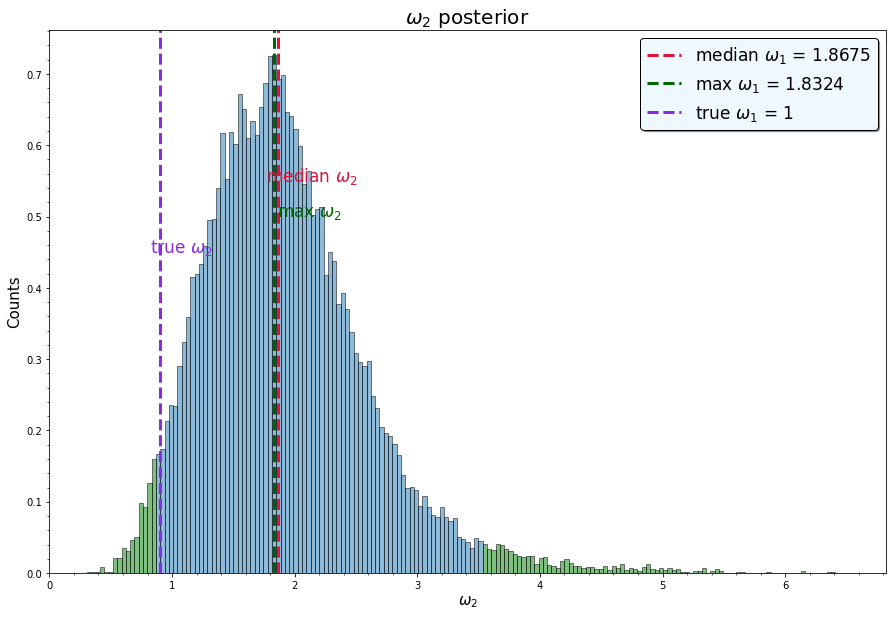

In [29]:
fig, ax, centers_omega2_s_r, counts_omega2_s_r= plot_func_sim(chain= chain_start_sim, true_value=0.9, parameter = 'omega_2', y_max=0.5, y_median=0.55, true_y = 0.45)

Median value of omega_1: 0.2786
Max value of omega_1: 0.23


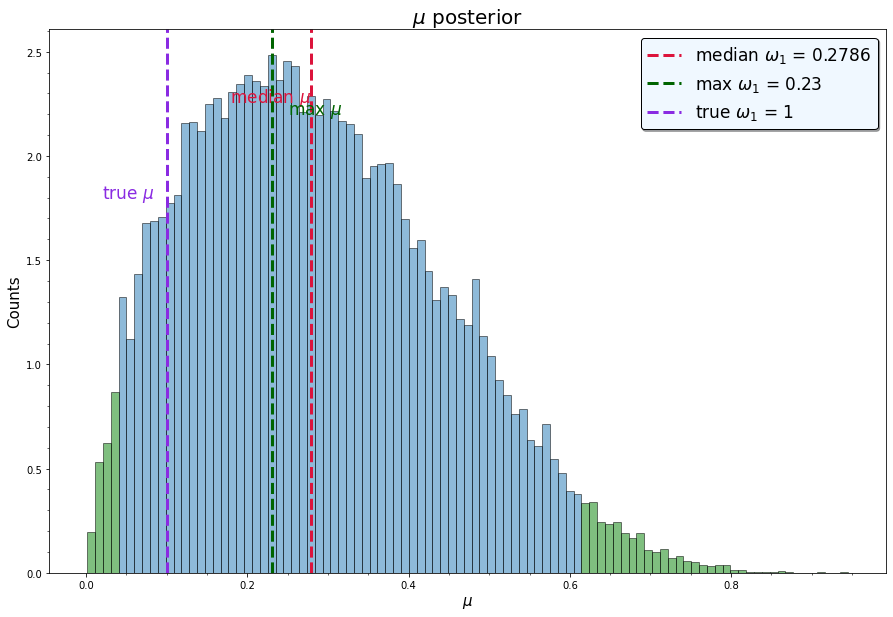

In [30]:
fig, ax,centers_mu_s_r, counts_mu_s_r= plot_func_sim(chain= chain_start_sim, true_value=0.1, parameter='mu')

Median value of omega_1: 1.5465
Max value of omega_1: 1.4042


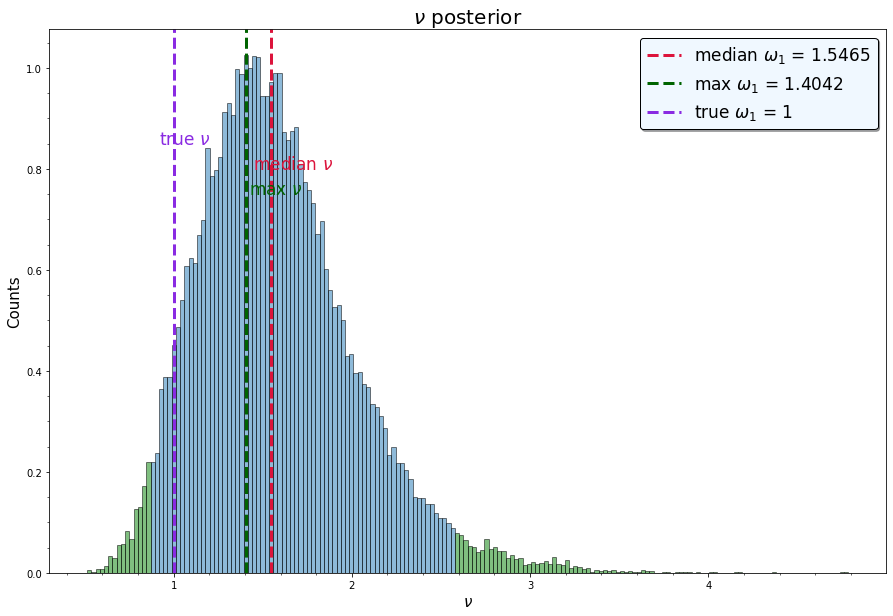

In [31]:
fig, ax,centers_nu_s_r, counts_nu_s_r = plot_func_sim(chain= chain_start_sim, true_value=1, parameter='nu', y_max=0.75, y_median=0.8, true_y = 0.85)

### Actung !

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: Th

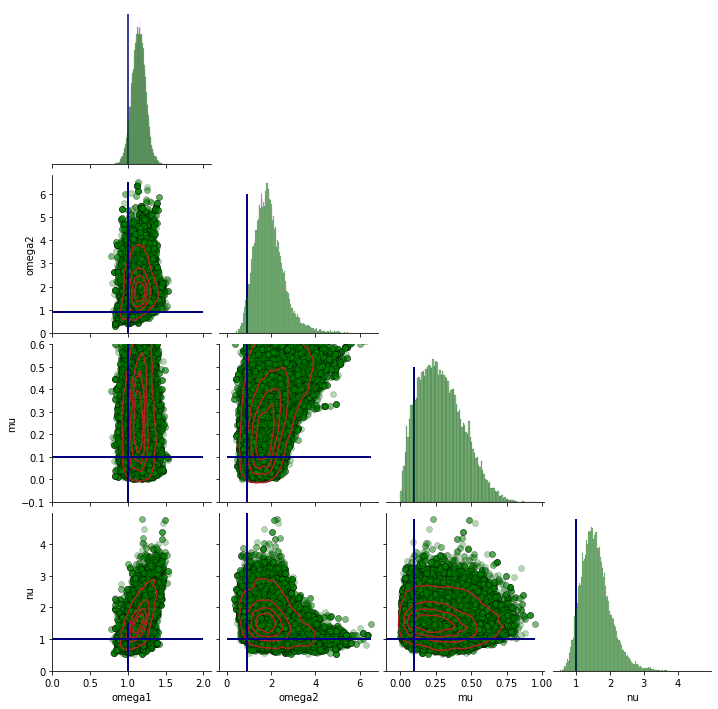

In [32]:
g = pairplot(chain=chain_start_sim)

In [33]:
def chains_plot(chain):
    fig , ax = plt.subplots(4,1, figsize=(25, 30))

    title_list = ['$\omega_1$', '$\omega_2$', '$\mu$', '$\\nu$']
    for i, i_title in zip(range(4), title_list):
        ax[i].scatter(range(0,chain.shape[0]) , chain[:,i], s=1)
        ax[i].set_ylabel('Value of the chain', fontsize=15)
        ax[i].set_xlabel('Iteration Step', fontsize=15)
        ax[i].set_title('Chain of '+i_title, fontsize=18)
        ax[i].minorticks_on()
    return fig, ax

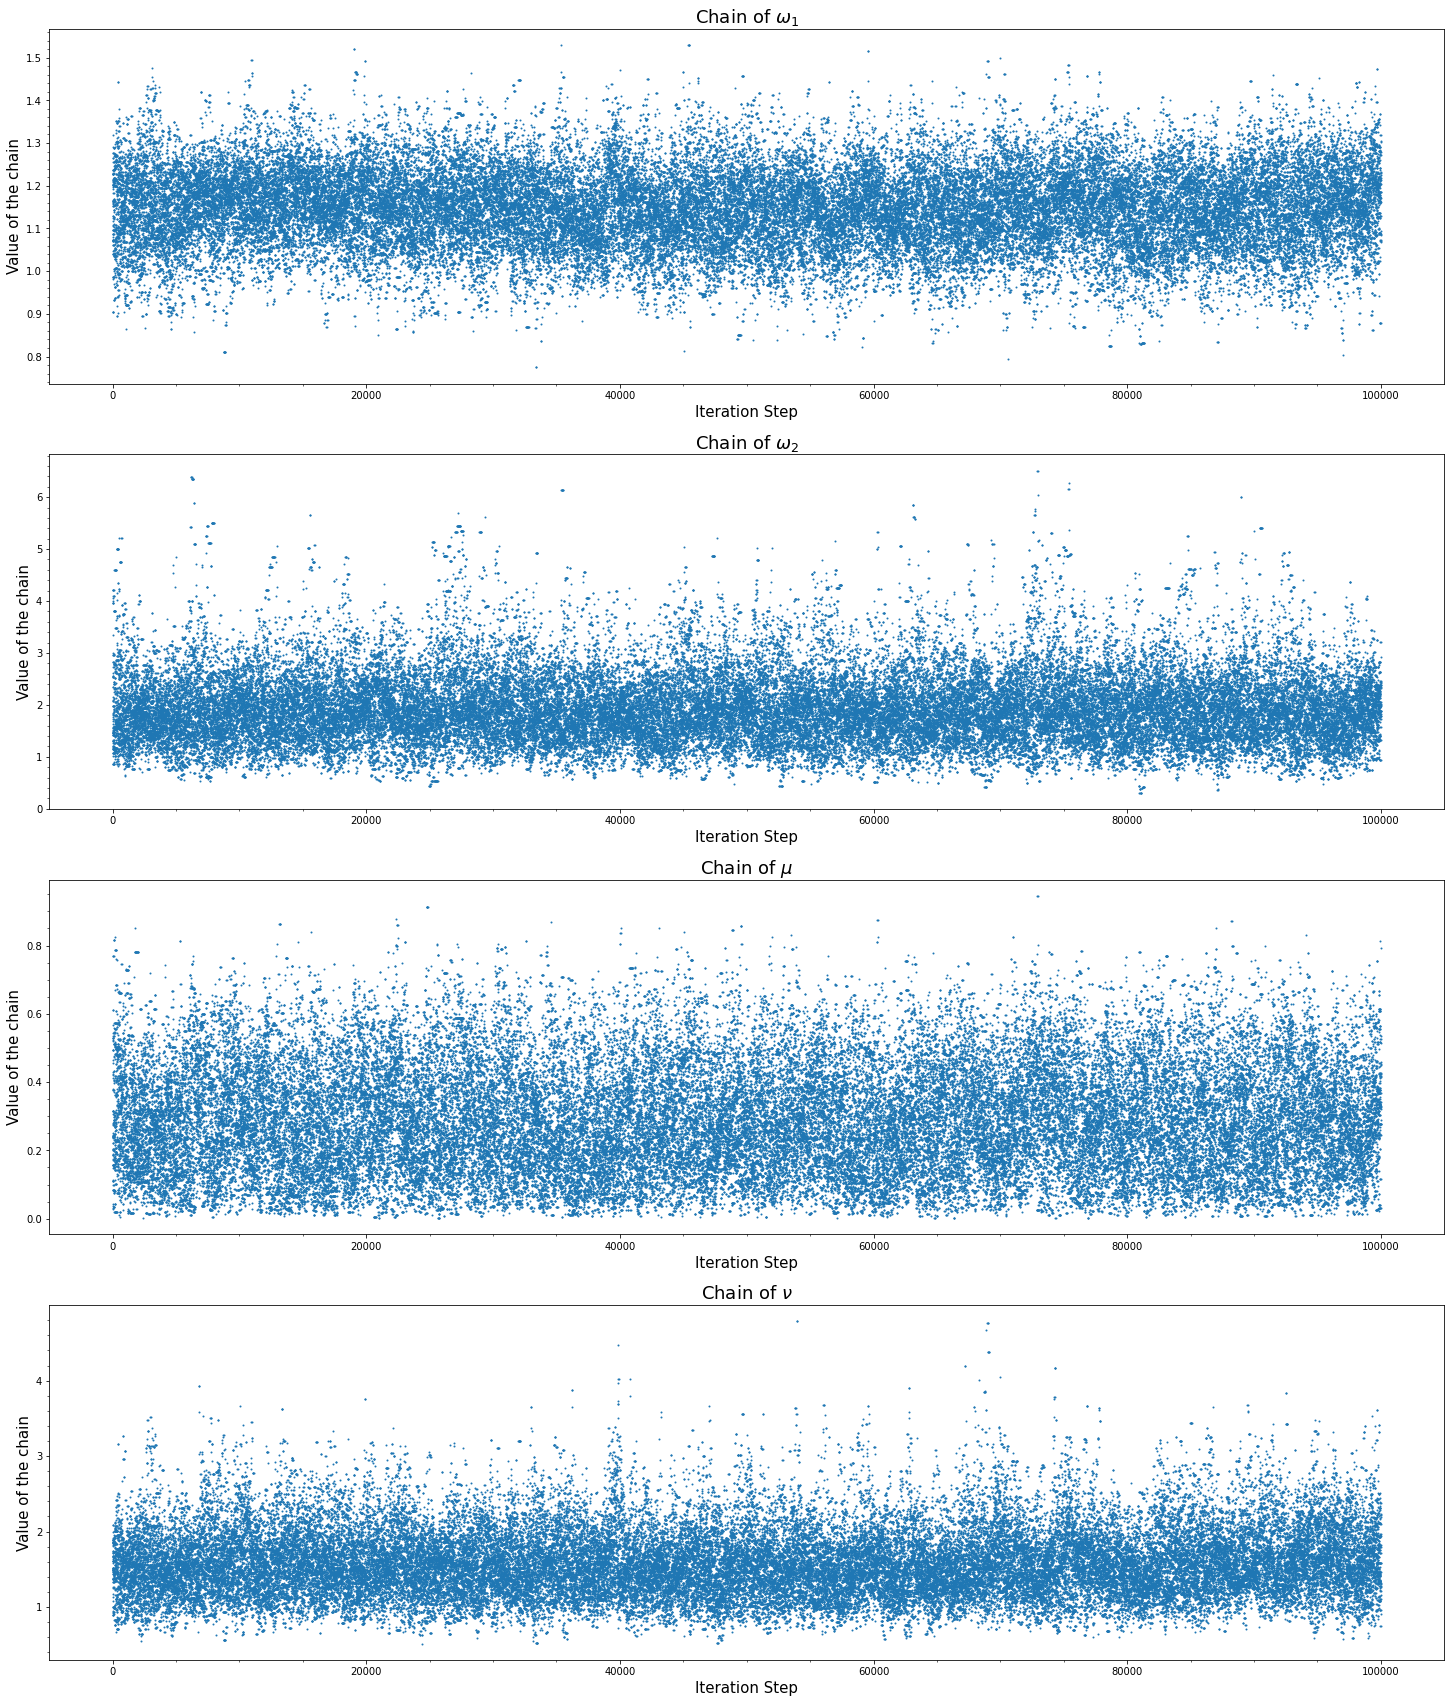

In [34]:
fig, ax = chains_plot(chain_start_sim)

## Model 1

In [35]:
'''
Cell size evolution x(t)
'''
def x_function_mod1(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    x_ = (xb)*np.exp(omega1*t)
    return x_


'''
Hazard rate function h(t)
'''
def h_mod1(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    h_ = omega2*((x_function_mod1(t, pars) + nu)/(mu+nu)) # if x(t) ≥ mu
    h_[x_function_mod1(t, pars) < mu] = 0                 # if x(t) < mu
    
    return h_


'''
Survival function s(t) for a float t
'''
def CDF_float(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    # threshold time
    t0 = max([0, ((1.0/omega1) * np.log(mu/xb))])

    if t>=t0:
        ln_s_ = - ( (xb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +\
                    (nu/(mu+nu)) * omega2 * (t-t0) )
    else:
        ln_s_ = 0
    

    s_ = np.exp(ln_s_)

    return s_


'''
Survival function s(t) for an array t
'''
def CDF_arr(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    # threshold time
    t0 = max([0, (1.0/omega1) * np.log(mu/xb)])
    
    ln_s_ = - ( (xb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) + (nu/(mu+nu)) * omega2 * (t-t0) )
    ln_s_[t < t0] = 0                 # if x(t) < mu

    s_ = np.exp(ln_s_)
    return s_

    
'''
Survival function s(t)
'''
def CDF_mod1(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    if type(t) == np.ndarray: # array
        s_ = CDF_arr(t, pars)
    else: # float
        s_ = CDF_float(t, pars)

    return s_

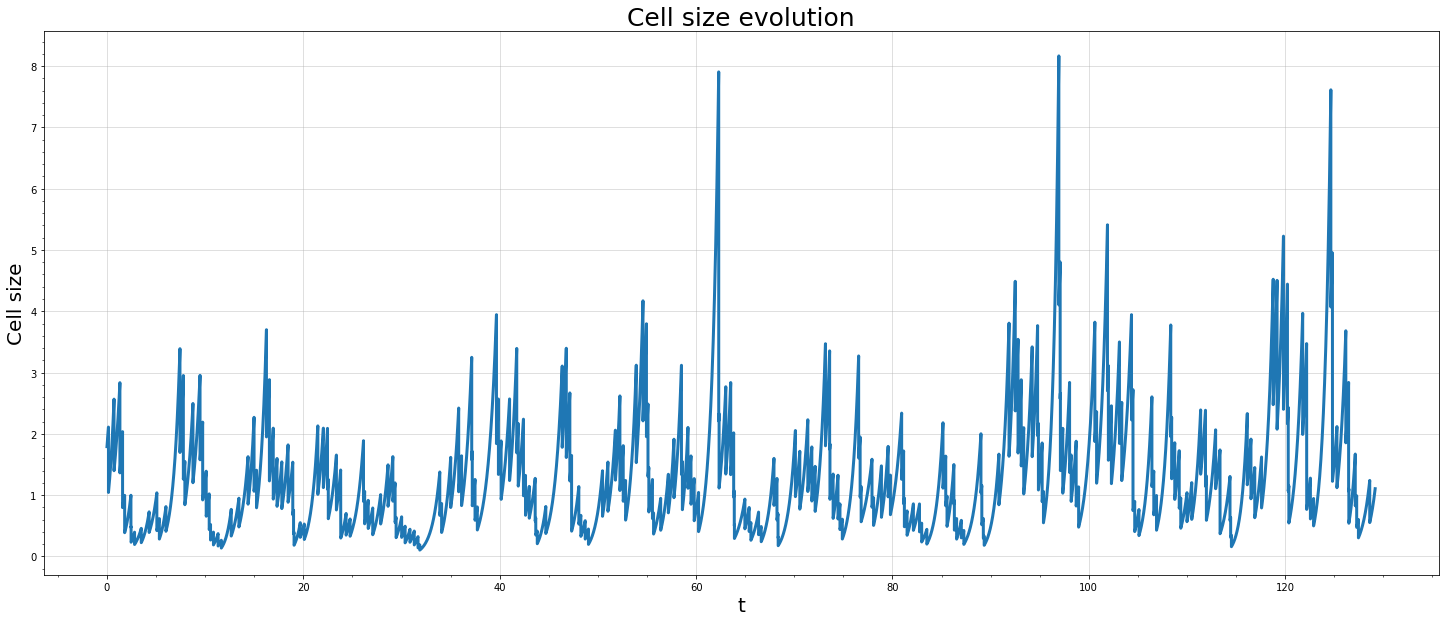

In [37]:
# simulate the time series
sim_t_1, all_times_1, cell_sizes_1 = sim_t_draw(CDF=CDF_mod1, x_function=x_function_mod1, points_per_evolution=points_per_evolution, xb=xb_realdata, model='1')
fig, ax = plot_evol(all_times=all_times_1, cell_sizes=cell_sizes_1)



In [38]:
def PDF_mod1(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    unnormalized = h_mod1(t, pars)*CDF_mod1(t, pars)
    idx = np.argsort(t)
    normalization = np.trapz(x=t[idx], y=unnormalized[idx])

    return(unnormalized/normalization)


In [39]:
# emcee
# n_walkers = 20

sampler = emcee.EnsembleSampler(n_walkers, 4, j_log_unnorm_posterior_emcee, kwargs={'y_times':sim_t_1, 'PDF':PDF_mod1}, a=2)
'''
3   is the number of dimensions in the parameter space
a=2 is the proposal scale parameter. (default: 2.0)
'''

pos, prob, state = sampler.run_mcmc(p0, 400)
sampler.reset()
sampler.run_mcmc(pos, 5000, rstate0=state)

chain_mod1_sim = sampler.get_chain(flat=True)

'''
p0   is the initial state
5000 is the number of steps to run
'''

<ipython-input-35-df2a8cc3b209>:51: RuntimeWarning: invalid value encountered in log
  t0 = max([0, (1.0/omega1) * np.log(mu/xb)])
<ipython-input-16-2b5923c49bae>:8: RuntimeWarning: divide by zero encountered in log
  ret = np.sum(np.log(PDF(y_times, pars=(omega_1, omega_2, u, nu, 1)))) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu)) + np.log(prior_omega2(omega_2))
<ipython-input-16-2b5923c49bae>:10: RuntimeWarning: invalid value encountered in double_scalars
  if ret*0 ==0:
<ipython-input-16-2b5923c49bae>:8: RuntimeWarning: invalid value encountered in log
  ret = np.sum(np.log(PDF(y_times, pars=(omega_1, omega_2, u, nu, 1)))) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu)) + np.log(prior_omega2(omega_2))
<ipython-input-35-df2a8cc3b209>:56: RuntimeWarning: overflow encountered in exp
  s_ = np.exp(ln_s_)
<ipython-input-38-e4864dd20302>:8: RuntimeWarning: invalid value encountered in true_divide
  return(unnormalized/normalizati

'\np0   is the initial state\n5000 is the number of steps to run\n'

### Plot posterior distributions and chains

Median value of omega_1: 1.0907
Max value of omega_1: 1.0703


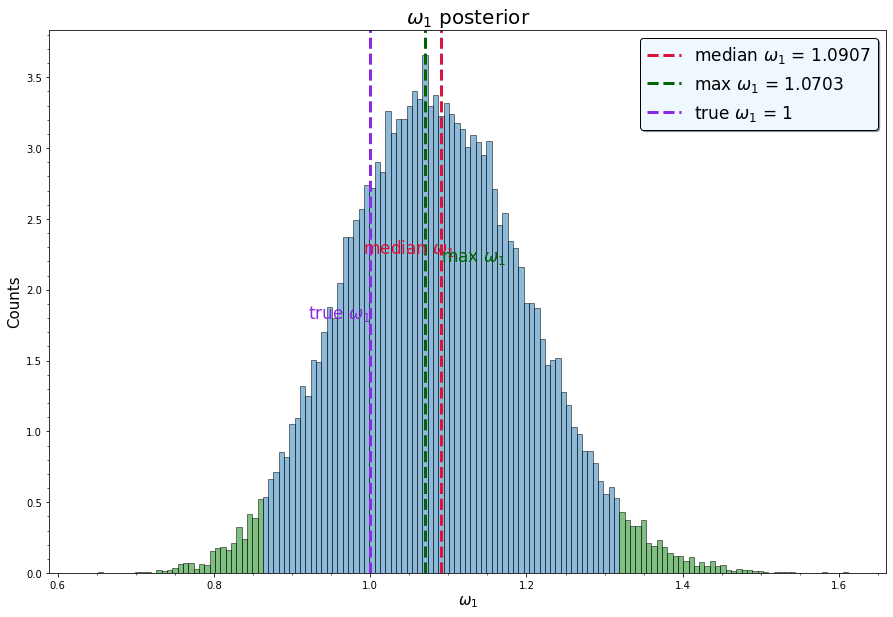

In [40]:
fig, ax, centers_omega_1_mod1, counts_omega_1_mod1 = plot_func_sim(chain= chain_mod1_sim, true_value=1, parameter='omega_1')

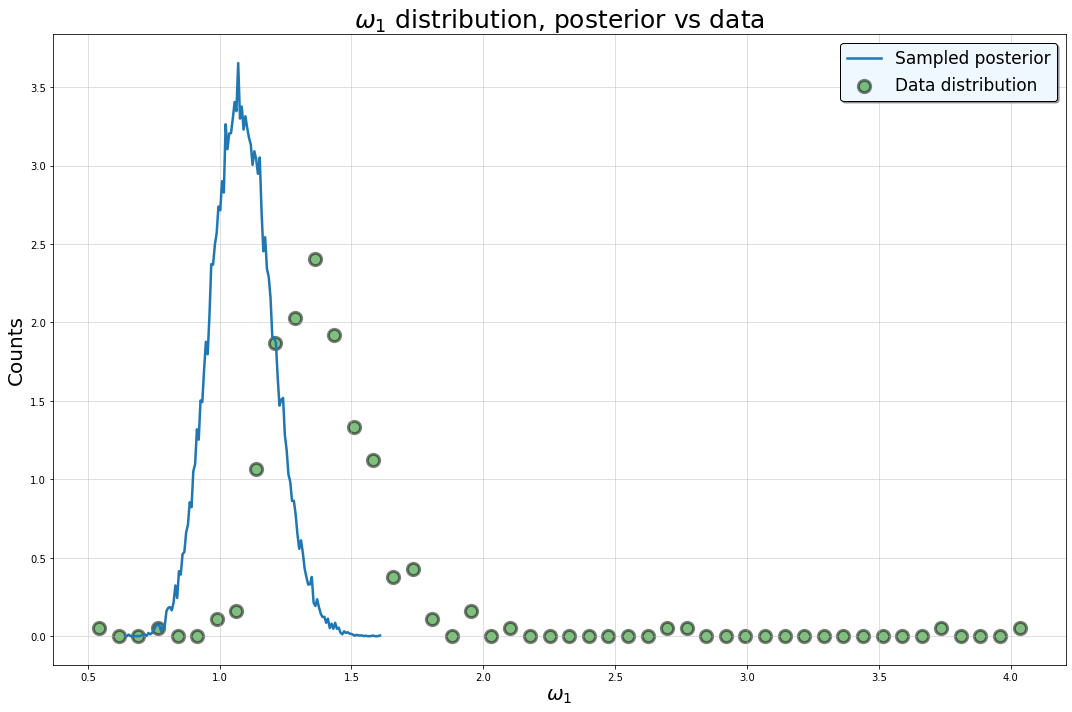

In [41]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.plot(centers_omega_1_mod1, counts_omega_1_mod1, label = 'Sampled posterior', linewidth=2.5)
ax.scatter(grow_centers, hist_val_grow[0], linewidth=3, s=150, color='green', edgecolor = 'black', alpha=0.5, label='Data distribution')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
ax.grid(alpha=0.5)
ax.set_xlabel('$\omega_1$', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.set_title('$\omega_1$ distribution, posterior vs data', fontsize = 25)
fig.tight_layout()

Median value of omega_1: 1.1066
Max value of omega_1: 1.1244


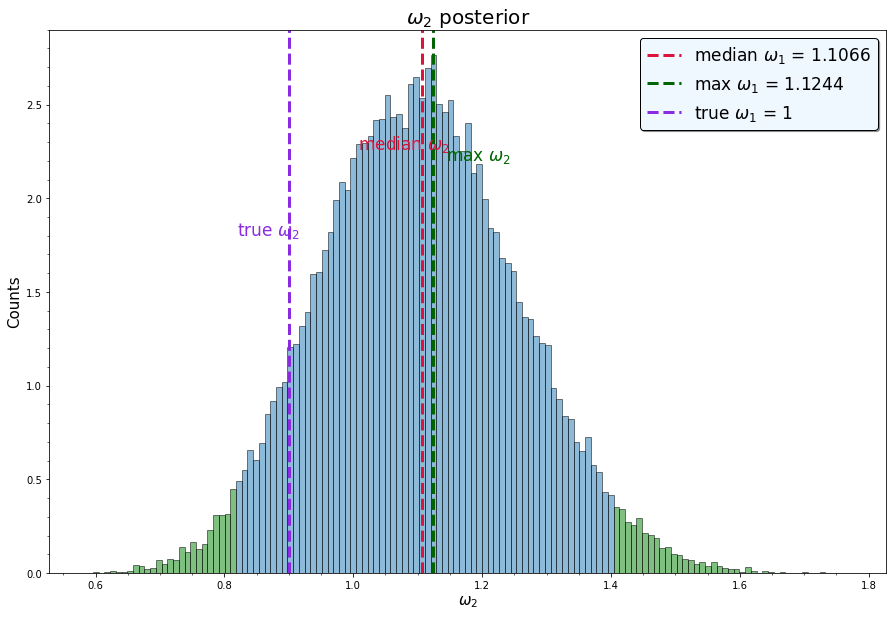

In [42]:
fig, ax,  centers_omega_2_mod1, counts_omega_2_mod1 = plot_func_sim(chain= chain_mod1_sim, true_value=0.9, parameter='omega_2')

Median value of omega_1: 0.2785
Max value of omega_1: 0.1908


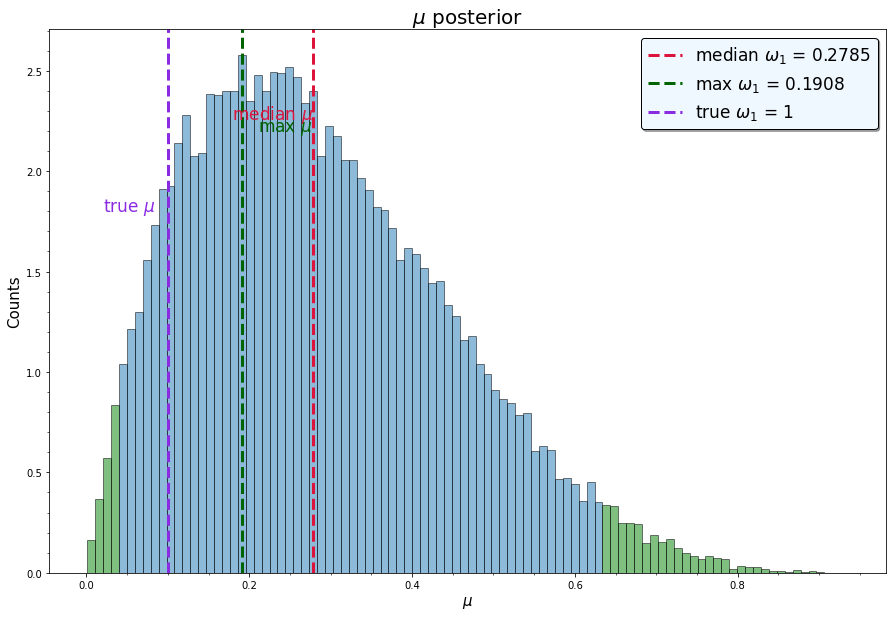

In [43]:
fig, ax,  centers_mu_mod1, counts_mu_mod1 = plot_func_sim(chain= chain_mod1_sim, true_value=0.1, parameter='mu')

Median value of omega_1: 1.7715
Max value of omega_1: 1.6787


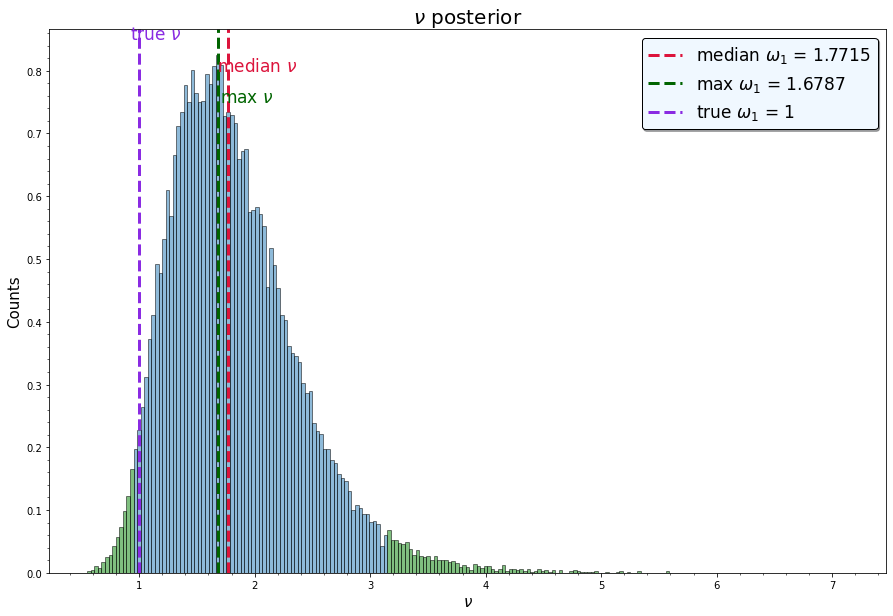

In [44]:
fig, ax, centers_nu_mod1, counts_nu_mod1 = plot_func_sim(chain= chain_mod1_sim, true_value=1, parameter='nu', y_median=0.8, y_max=0.75, true_y=0.85)

### Actung!

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: Th

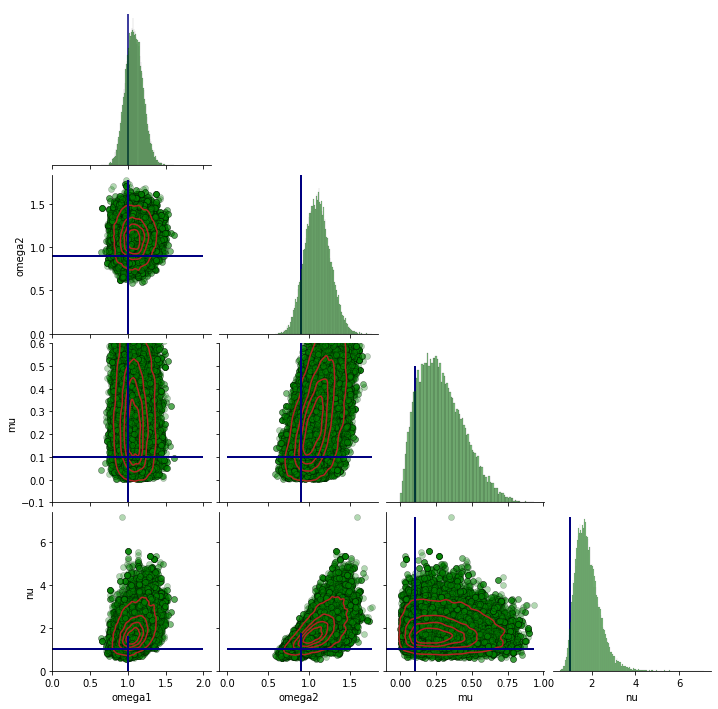

In [45]:
g = pairplot(chain=chain_mod1_sim)

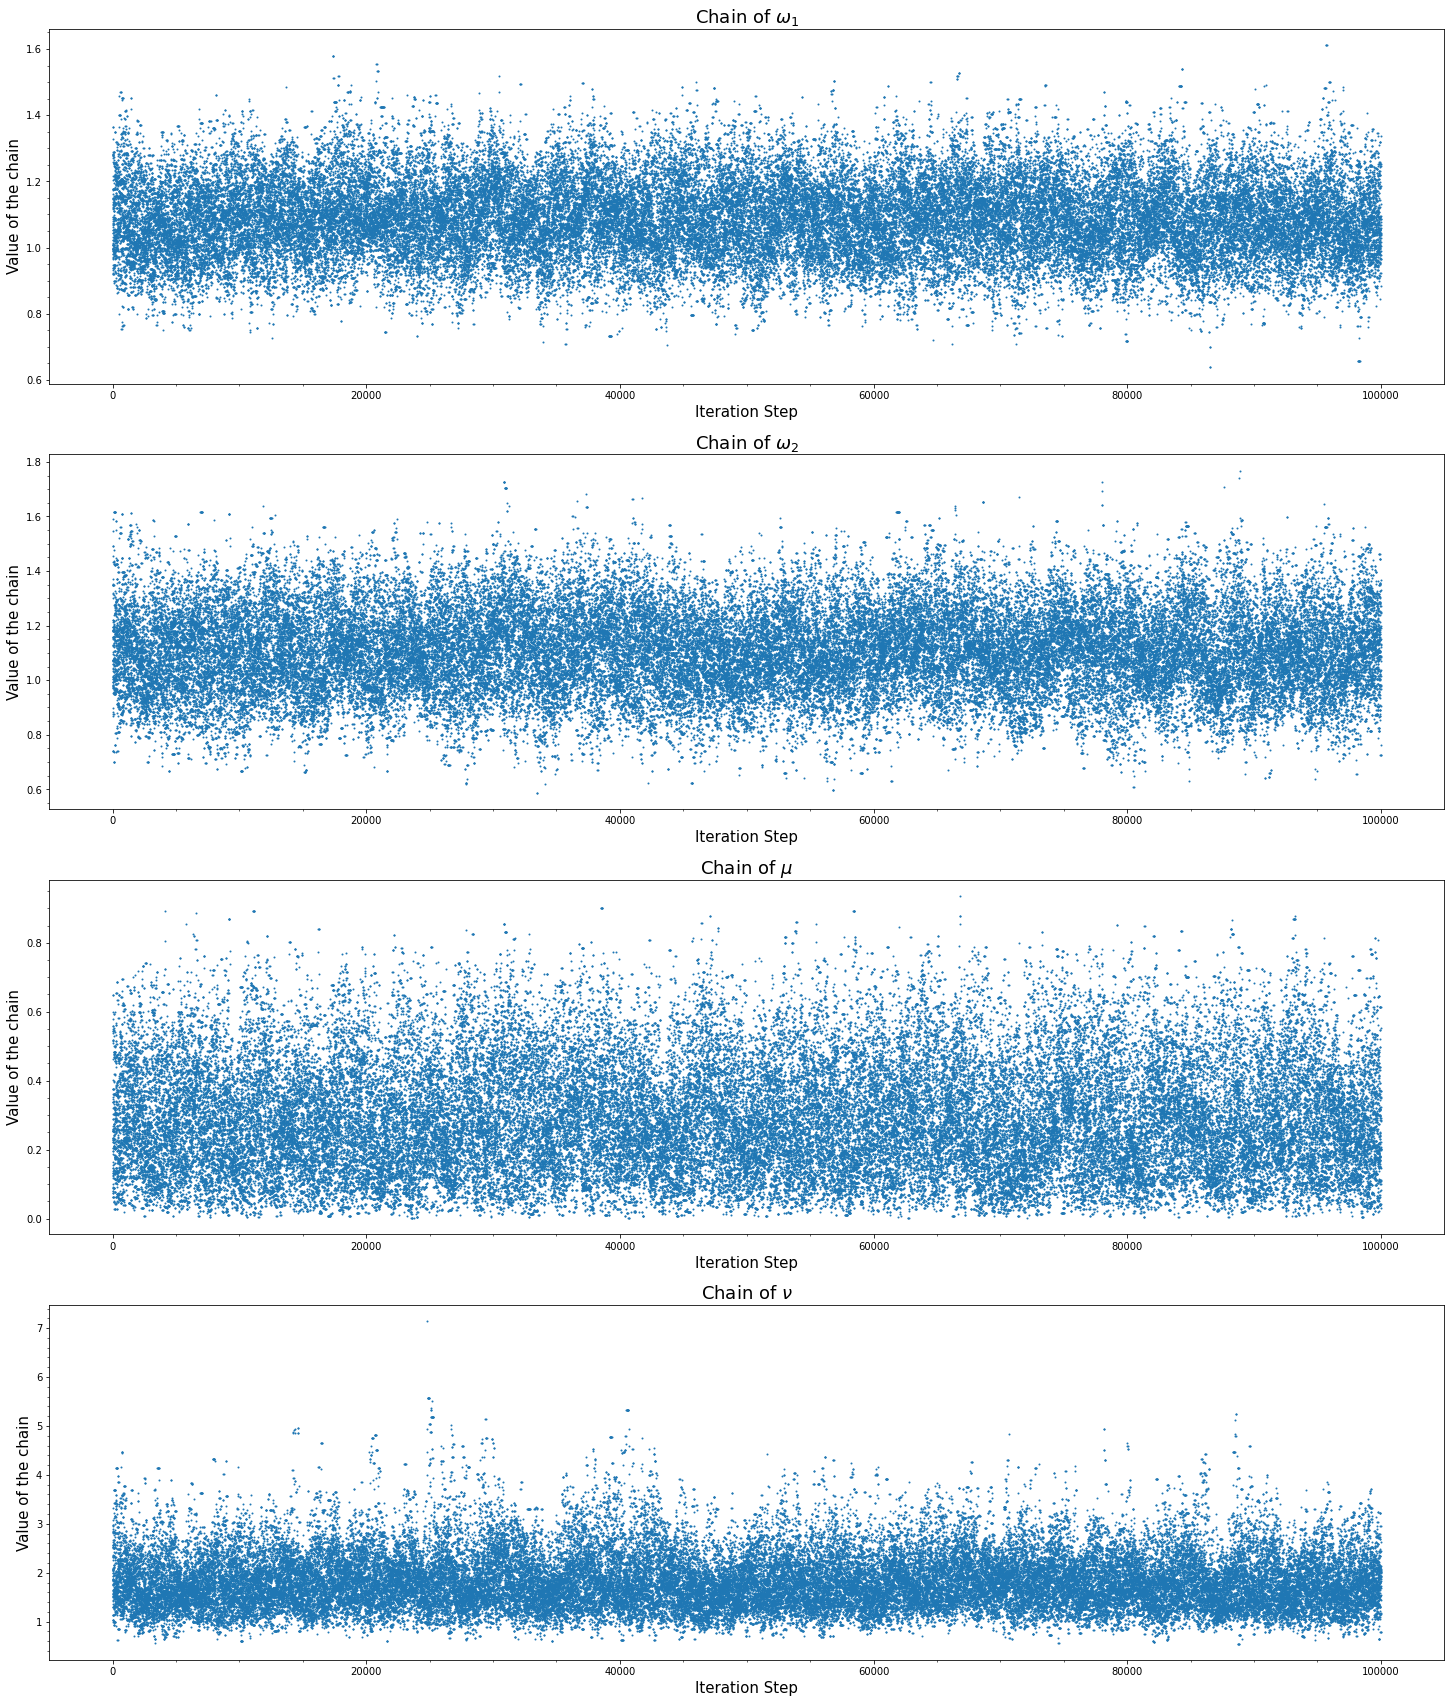

In [46]:
fig, ax = chains_plot(chain_mod1_sim)

## Model 2

In [47]:
'''
Cell size evolution m(t)
'''
def m_function(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    m_ = (mb)*np.exp(omega1*t)
    return m_


'''
Protein content evolution p(t)
'''
def p_function(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    
    p_ = (mb)*(np.exp(omega1*t) - 1)
    return p_


'''
Hazard rate function h(t)
'''
def h_mod2(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    h_ = omega2*((p_function(t, pars) + nu)/(mu+nu)) # if p(t) ≥ mu
    h_[p_function(t, pars) < mu] = 0                 # if p(t) < mu
    
    return h_


'''
Survival function s(t) for a float t
'''
def CDF_float_mod2(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    # threshold time
    
    t0 = (1.0/omega1) * np.log(1 + (mu/mb))
    #t0 = max([0, (1.0/omega1) * np.log(1 + (mu/mb))])
    if t>=t0:
        ln_s_ = - ( (mb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +\
                    ((nu-mb)/(mu+nu)) * omega2 * (t-t0) )
        #ln_s_ =  ( (mb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t0)-np.exp(omega1*t)) +\
        #            ((mu-mb)/(mu+nu)) * omega2 * (t0-t) )
    else:
        ln_s_ = 0
        

    s_ = np.exp(ln_s_)

    return s_


'''
Survival function s(t) for an array t
'''
# threshold time

def CDF_arr_mod2(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    t0 = (1.0/omega1) * np.log(1 + (mu/mb))
    #t0 = max([0, (1.0/omega1) * np.log(1 + (mu/mb))])

    ln_s_ = - ( (mb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +((nu-mb)/(mu+nu)) * omega2 * (t-t0) )
    #ln_s_ = - ( (mb/(mu+nu)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +((mu-mb)/(mu+nu)) * omega2 * (t-t0) )
    
    
    ln_s_[t < t0] = 0                 # if p(t) < mu

    s_ = np.exp(ln_s_)

    return s_


'''
Survival function s(t)
'''
def CDF_mod2(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, mb) = pars

    if type(t) == np.ndarray: # array
        s_ = CDF_arr_mod2(t, pars)
    else: # float
        s_ = CDF_float_mod2(t, pars)

    return s_

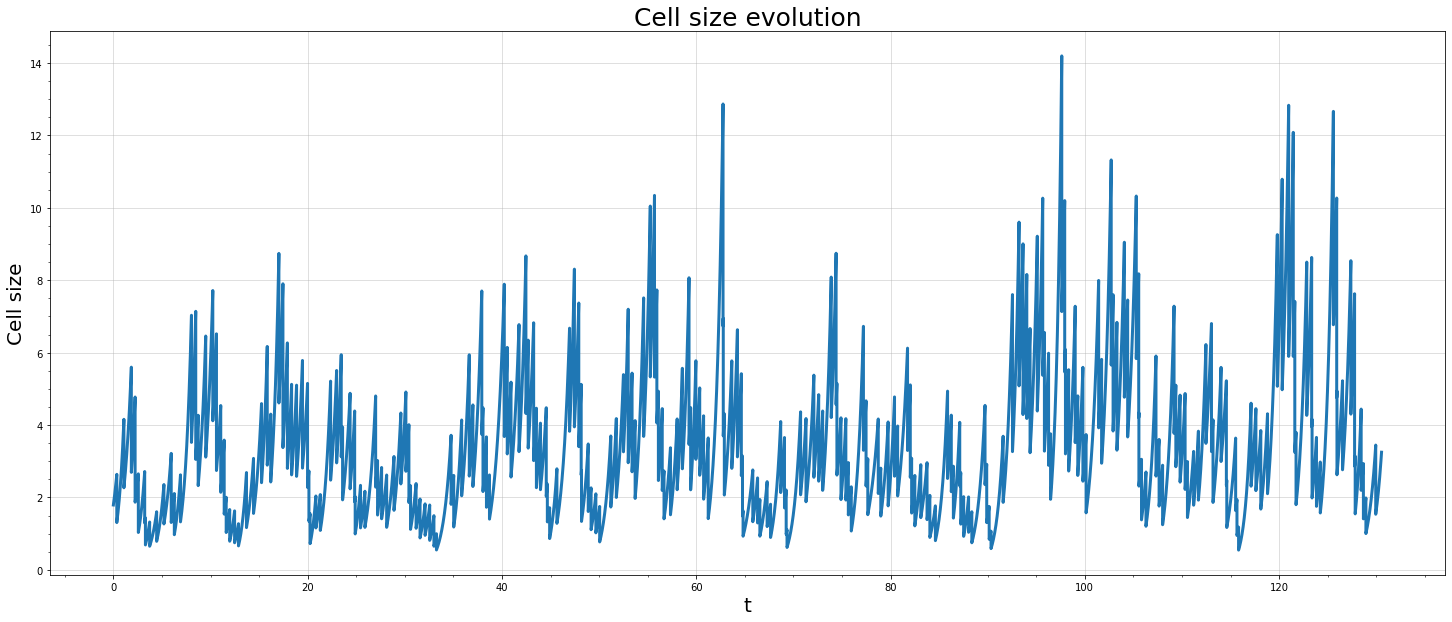

In [49]:
# simulate the time series
sim_t_2, all_times_2, cell_sizes_2 = sim_t_draw(CDF=CDF_mod2, x_function=m_function, points_per_evolution=points_per_evolution, xb=xb_realdata, model='2')
fig, ax = plot_evol(all_times=all_times_2, cell_sizes=cell_sizes_2)



In [50]:
def PDF_mod2(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    unnormalized = h_mod2(t, pars)*CDF_mod2(t, pars)
    idx = np.argsort(t)
    normalization = np.trapz(x=t[idx], y=unnormalized[idx])

    return(unnormalized/normalization)

In [51]:
# emcee
# n_walkers = 20

sampler = emcee.EnsembleSampler(n_walkers, 4, j_log_unnorm_posterior_emcee, kwargs={'y_times':sim_t_2, 'PDF':PDF_mod2}, a=2)
'''
3   is the number of dimensions in the parameter space
a=2 is the proposal scale parameter. (default: 2.0)
'''

pos, prob, state = sampler.run_mcmc(p0, 400)
sampler.reset()
sampler.run_mcmc(pos, 5000, rstate0=state)
'''
p0   is the initial state
5000 is the number of steps to run
'''


<ipython-input-16-2b5923c49bae>:8: RuntimeWarning: divide by zero encountered in log
  ret = np.sum(np.log(PDF(y_times, pars=(omega_1, omega_2, u, nu, 1)))) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu)) + np.log(prior_omega2(omega_2))
<ipython-input-16-2b5923c49bae>:10: RuntimeWarning: invalid value encountered in double_scalars
  if ret*0 ==0:
/root/venv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
<ipython-input-16-2b5923c49bae>:8: RuntimeWarning: invalid value encountered in log
  ret = np.sum(np.log(PDF(y_times, pars=(omega_1, omega_2, u, nu, 1)))) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu)) + np.log(prior_omega2(omega_2))
<ipython-input-47-749b7c7a65a5>:75: RuntimeWarning: overflow encountered in exp
  s_ = np.exp(ln_s_)
<ipython-input-50-fe502c2483f2>:4: RuntimeWarning: overflow encountered in multiply
  unn

'\np0   is the initial state\n5000 is the number of steps to run\n'

In [52]:
chain_mod2_sim = sampler.get_chain(flat=False)

# remove outliers (stucked chains) and flatten 
chain_mod2_sim = chain_mod2_sim[:, np.invert(np.all(chain_mod2_sim == chain_mod2_sim[0], axis=0))].reshape(-1, 4)

### Plot posterior distributions and chains

Median value of omega_1: 1.3689
Max value of omega_1: 1.3229


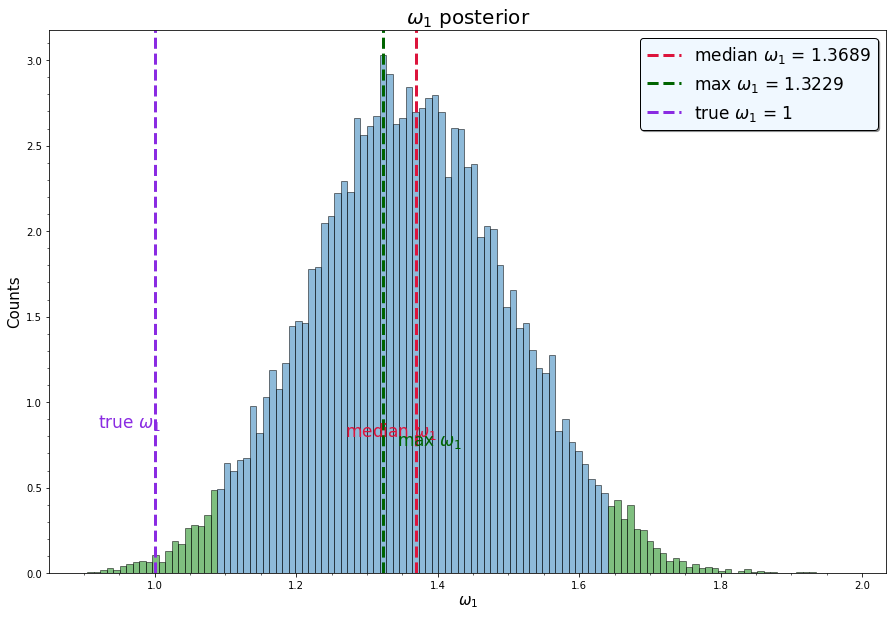

In [53]:
fig, ax, centers_omega_1_mod2, counts_omega_1_mod2 = plot_func_sim(chain= chain_mod2_sim, true_value=1, parameter='omega_1', y_median=0.8, y_max=0.75, true_y=0.85)

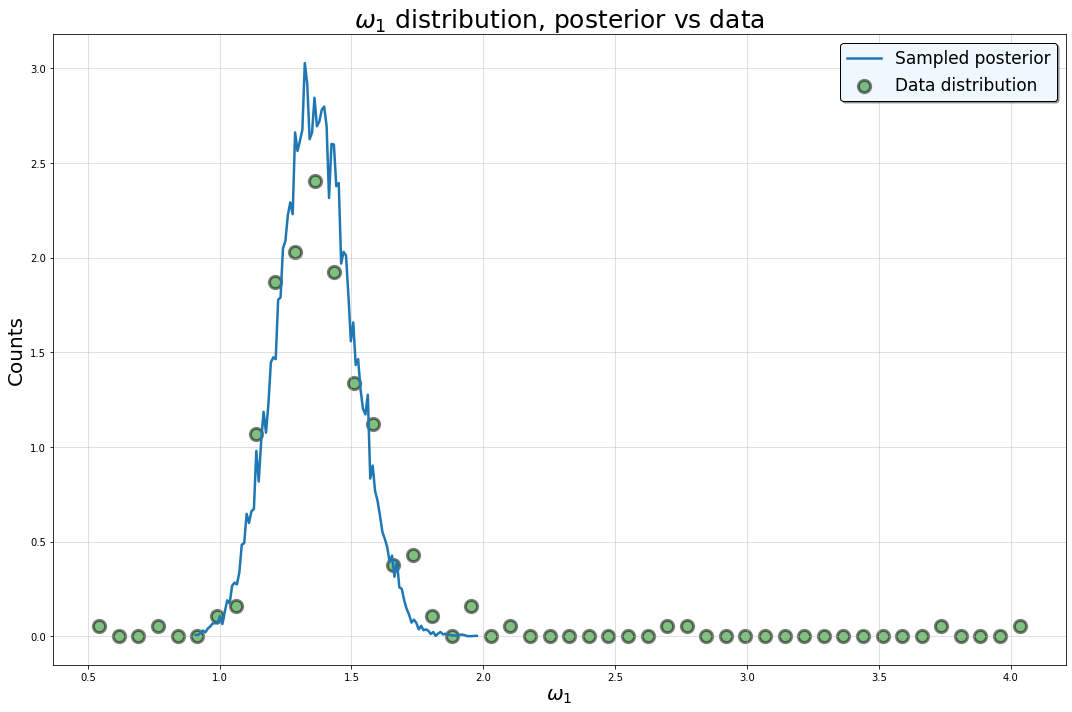

In [54]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.plot(centers_omega_1_mod2, counts_omega_1_mod2, label = 'Sampled posterior', linewidth=2.5)
ax.scatter(grow_centers, hist_val_grow[0], linewidth=3, s=150, color='green', edgecolor = 'black', alpha=0.5, label='Data distribution')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
ax.grid(alpha=0.5)
ax.set_xlabel('$\omega_1$', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.set_title('$\omega_1$ distribution, posterior vs data', fontsize = 25)
fig.tight_layout()

Median value of omega_1: 1.1048
Max value of omega_1: 1.0541


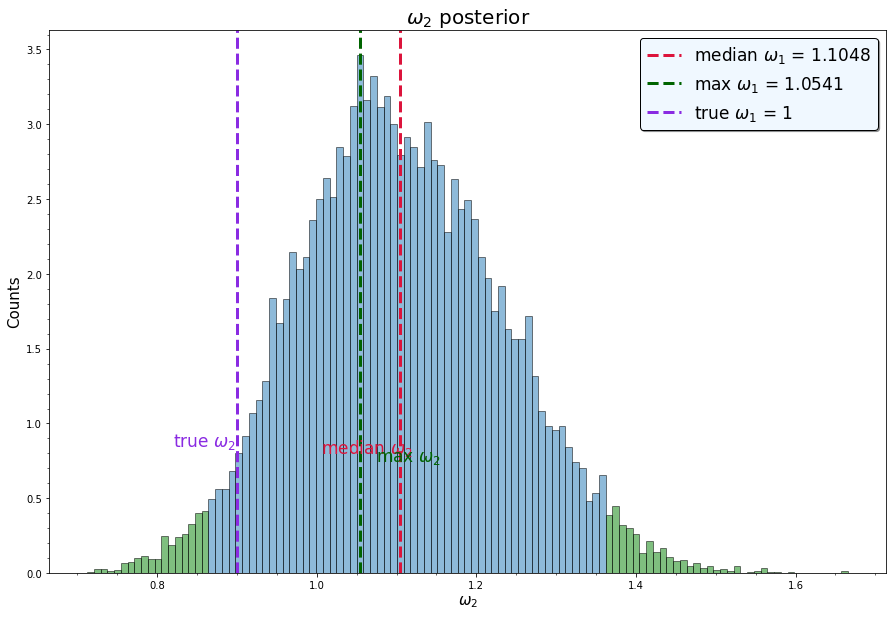

In [55]:
fig, ax, centers_omega_2_mod2, counts_omega_2_mod2 = plot_func_sim(chain= chain_mod2_sim, true_value=0.9, parameter='omega_2', y_median=0.8, y_max=0.75, true_y=0.85)

Median value of omega_1: 0.0174
Max value of omega_1: 0.0205


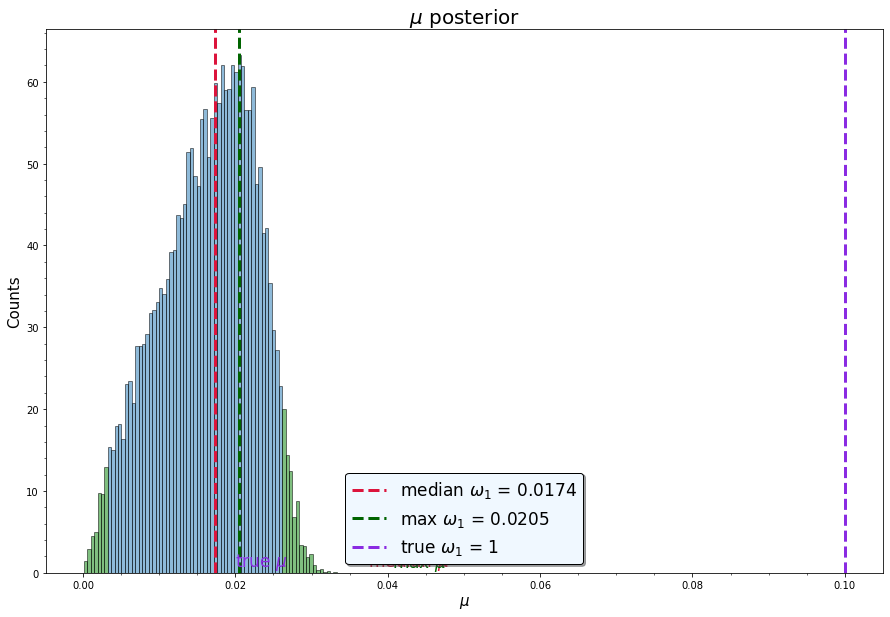

In [56]:
fig, ax, centers_mu_mod2, counts_mu_mod2 = plot_func_sim(chain= chain_mod2_sim, true_value=0.1, parameter='mu', y_median=0.8, y_max=0.75, true_y=0.85, x_median = 0.02)

Median value of omega_1: 1.0359
Max value of omega_1: 0.9384


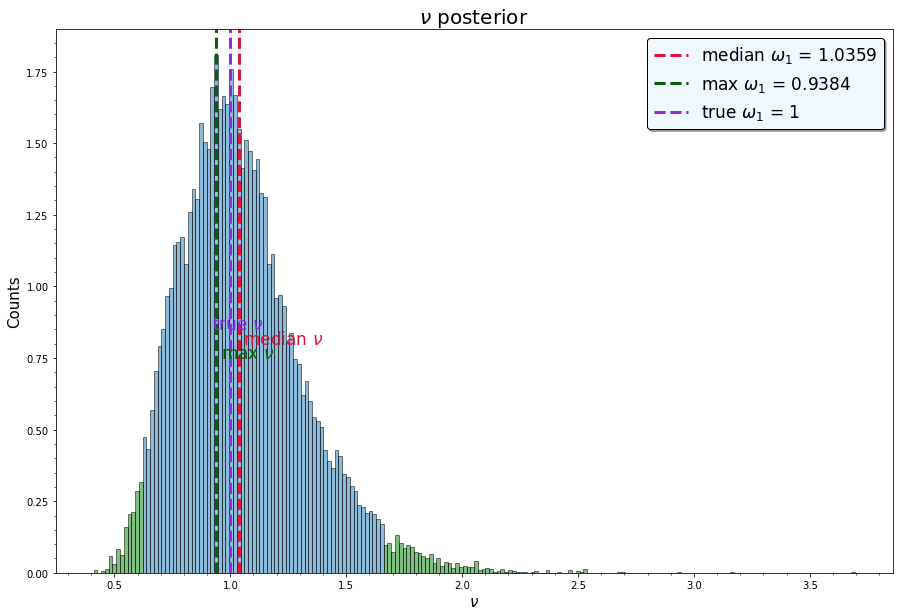

In [57]:
fig, ax, centers_nu_mod2, counts_nu_mod2 = plot_func_sim(chain= chain_mod2_sim, true_value=1, parameter='nu', y_median=0.8, y_max=0.75, true_y=0.85, x_median = 0.02)

## Actung!

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: Th

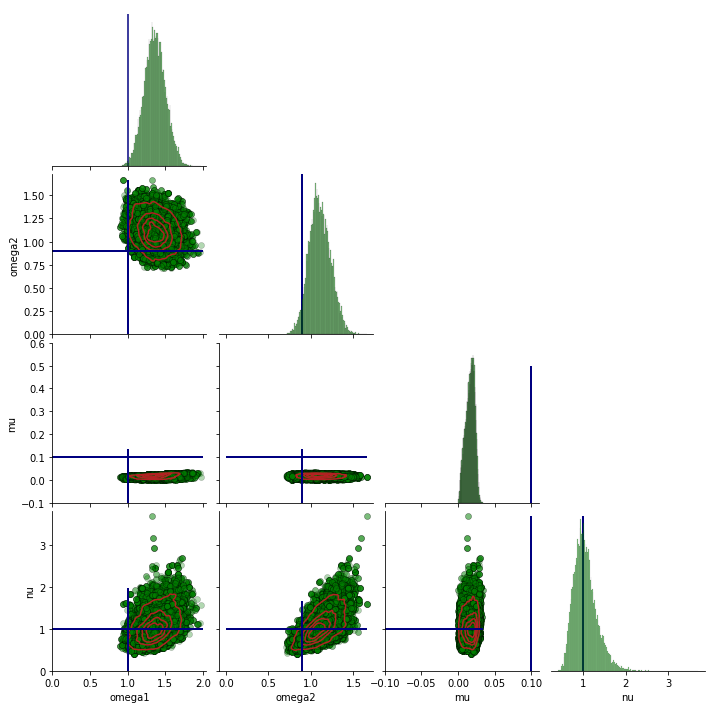

In [58]:
g = pairplot(chain=chain_mod2_sim)

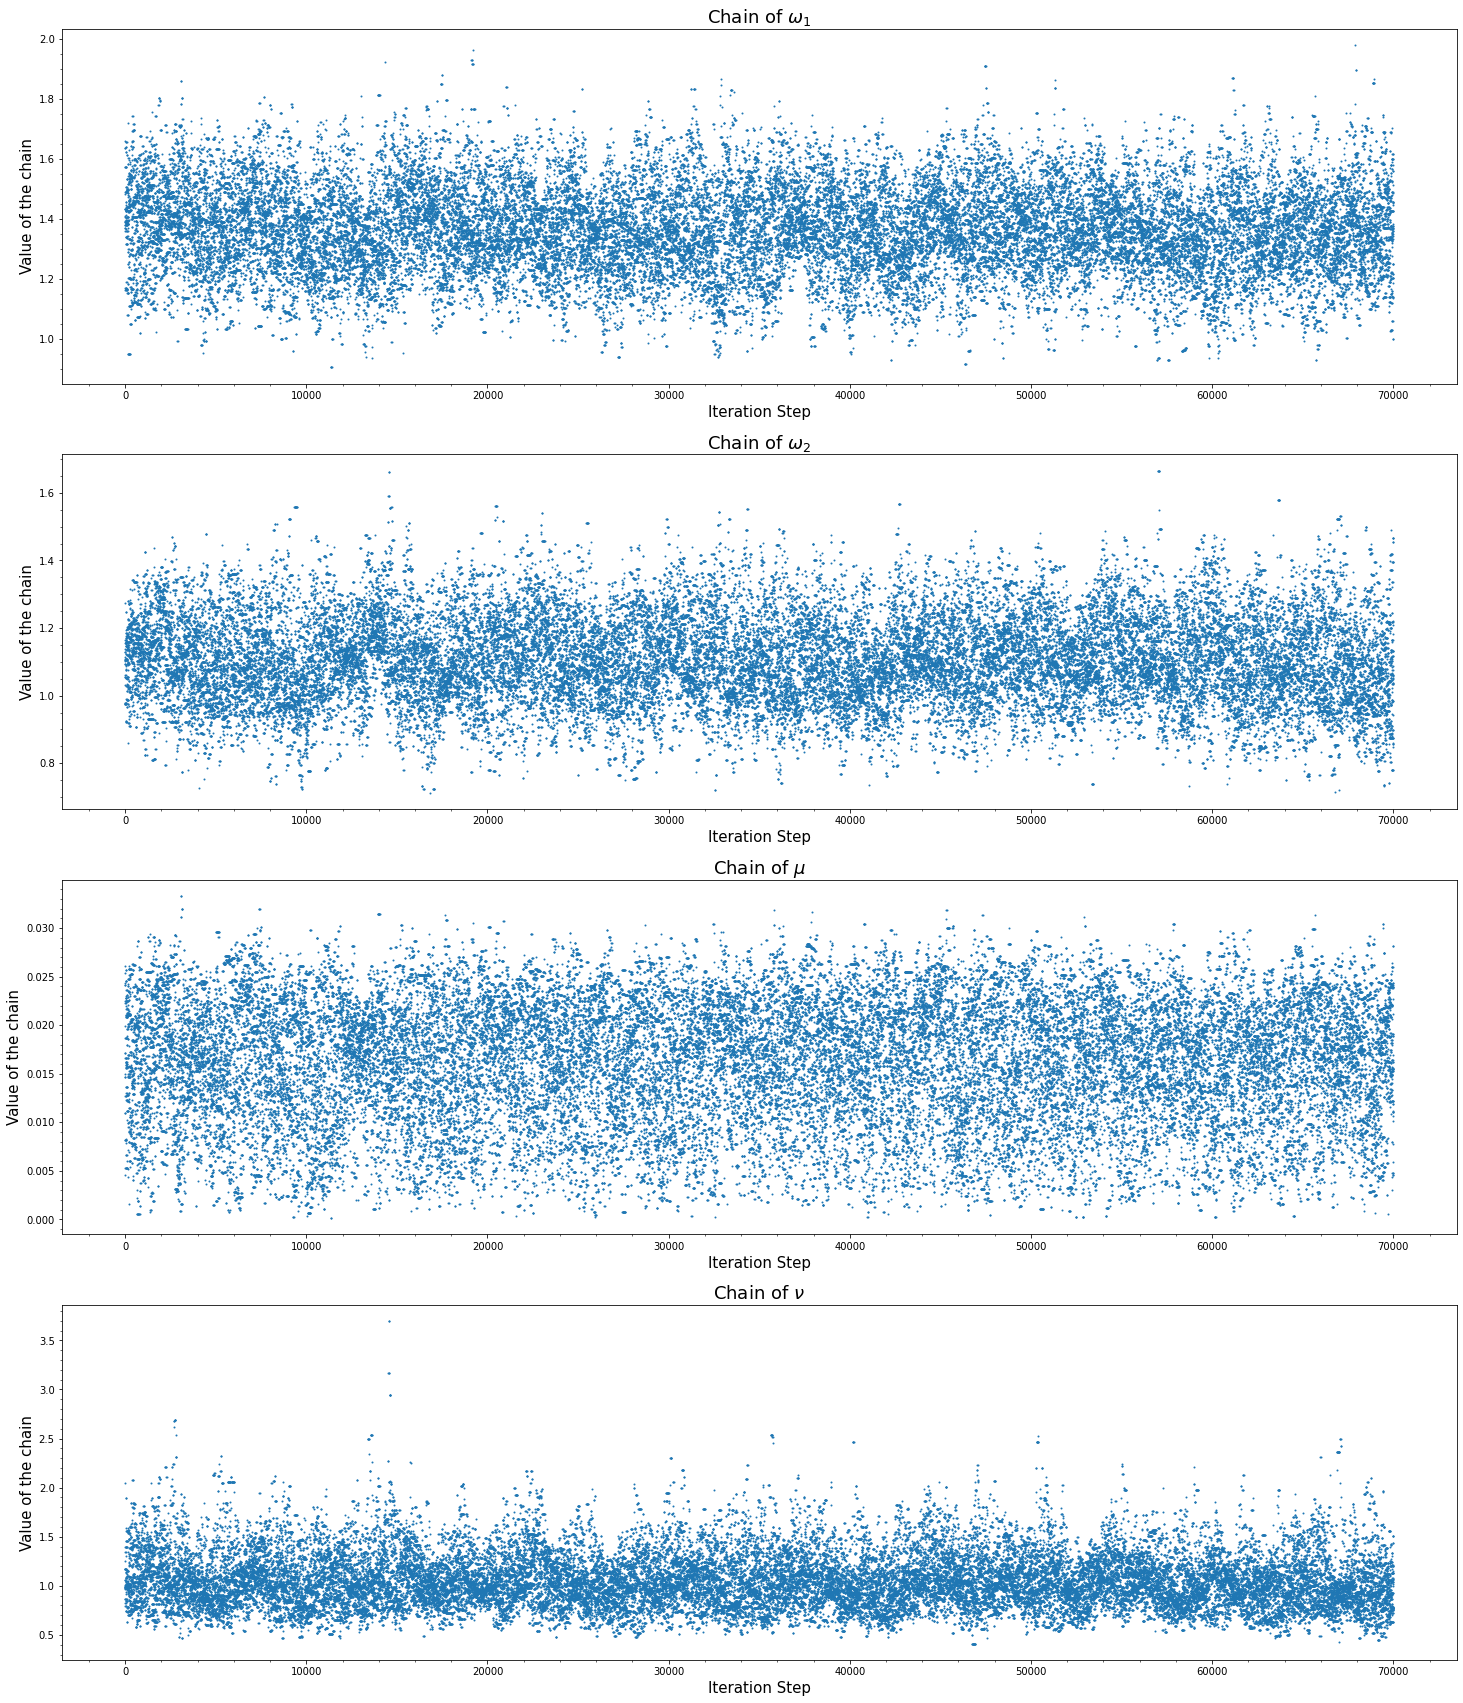

In [59]:
fig, ax = chains_plot(chain_mod2_sim)

# Real data

In [60]:
data_t = np.array(df_microbial_growth['generationtime'])

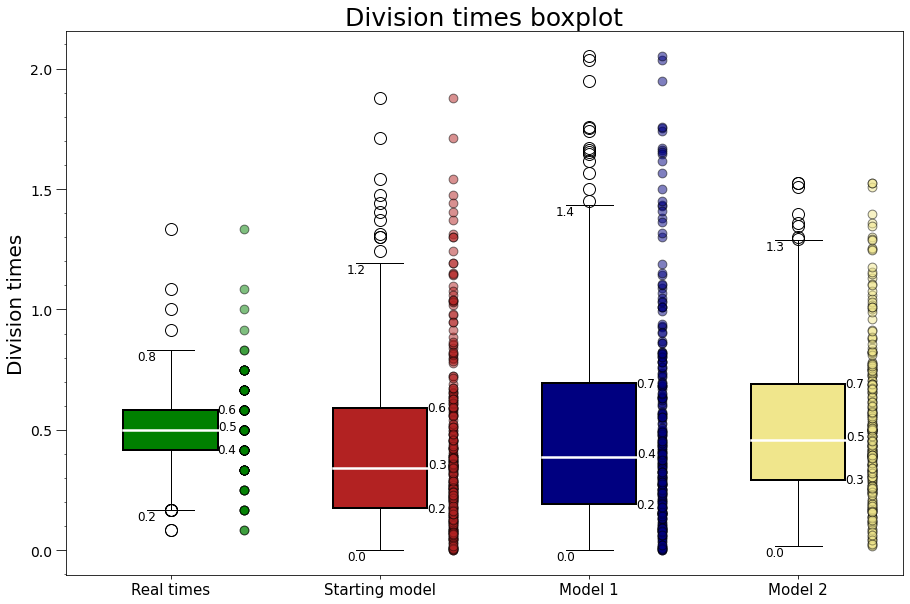

In [61]:

res= boxplot.boxplot([data_t, sim_t_starting, sim_t_1, sim_t_2],['green', 'firebrick', 'navy', 'khaki'], \
                ylabel= 'Division times', y_font=20, title='Division times boxplot',  font_title = 25,\
                color_median='white', linewidth_median=2.5 ,labels=True, list_labels=['Real times', 'Starting model', 'Model 1', 'Model 2'], xlabel='')
fig, ax, bp = res[0], res[1], res[2]
ax.set_xticklabels(['Real times', 'Starting model', 'Model 1', 'Model 2'], fontdict={'fontsize':15})


for line in bp['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] #  median line
    # overlay median value
    ax.text(x+0.05, y, '%.1f' % y,
         horizontalalignment='center', fontsize=12) # draw above, centered

for line in bp['caps']:
    x, y = line.get_xydata()[0] # bottom of left line
    ax.text(x,y, '%.1f' % y,
         horizontalalignment='center', # centered
         verticalalignment='top', fontsize=12)  
         

for line in bp['whiskers']:
    x, y = line.get_xydata()[0] # bottom of left line
    ax.text(x+0.27,y, '%.1f' % y,
         horizontalalignment='center', # centered
         verticalalignment='center', fontsize=12)   


    

In [62]:
sampler = emcee.EnsembleSampler(n_walkers, 4, j_log_unnorm_posterior_emcee, kwargs={'y_times': df_microbial_growth['generationtime'], 'PDF':PDF_start}, a=2)
'''
3   is the number of dimensions in the parameter space
a=2 is the proposal scale parameter. (default: 2.0)
'''

pos, prob, state = sampler.run_mcmc(p0, 500)
sampler.reset()
sampler.run_mcmc(pos, 1000, rstate0=state)

chain_start_real = sampler.get_chain(flat=True)


<ipython-input-16-2b5923c49bae>:8: RuntimeWarning: divide by zero encountered in log
  ret = np.sum(np.log(PDF(y_times, pars=(omega_1, omega_2, u, nu, 1)))) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu)) + np.log(prior_omega2(omega_2))
<ipython-input-16-2b5923c49bae>:10: RuntimeWarning: invalid value encountered in double_scalars
  if ret*0 ==0:
/shared-libs/python3.8/py/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/shared-libs/python3.8/py/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/shared-libs/python3.8/py/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/shared-libs/python3.8/py/lib/python3.8/site-packages/numpy/lib/func

Median value of omega_1: 2.076
Max value of omega_1: 2.0611


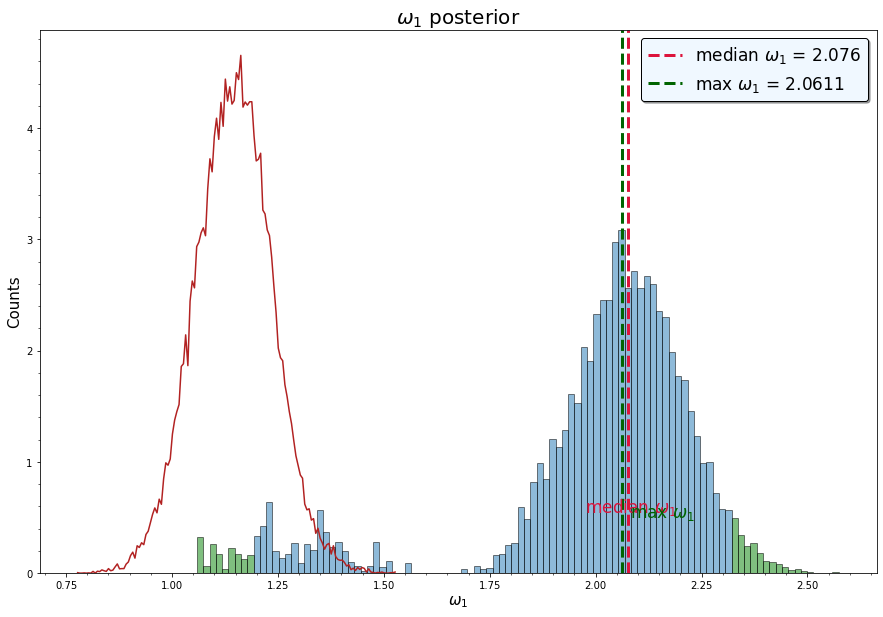

In [63]:
fig, ax, _, _ = plot_func_real(chain= chain_start_real, parameter = 'omega_1', y_max=0.5, y_median=0.55)
ax.plot(centers_omega1_s_r, counts_omega1_s_r, color='firebrick')

Median value of omega_1: 6.1718
Max value of omega_1: 5.8033


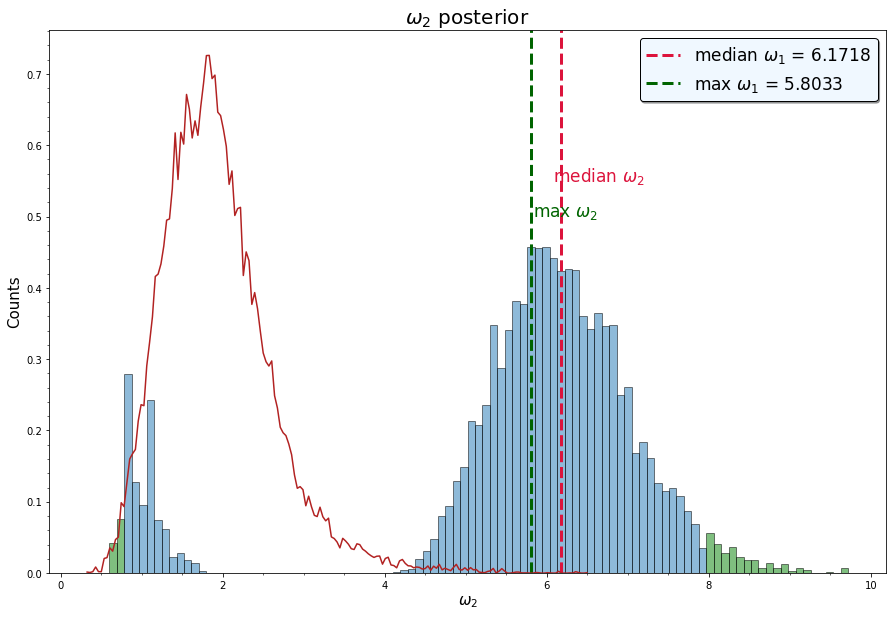

In [64]:
fig, ax, _, _ = plot_func_real(chain= chain_start_real, parameter = 'omega_2', y_max=0.5, y_median=0.55)
ax.plot(centers_omega2_s_r, counts_omega2_s_r, color='firebrick')

Median value of omega_1: 0.8323
Max value of omega_1: 0.854


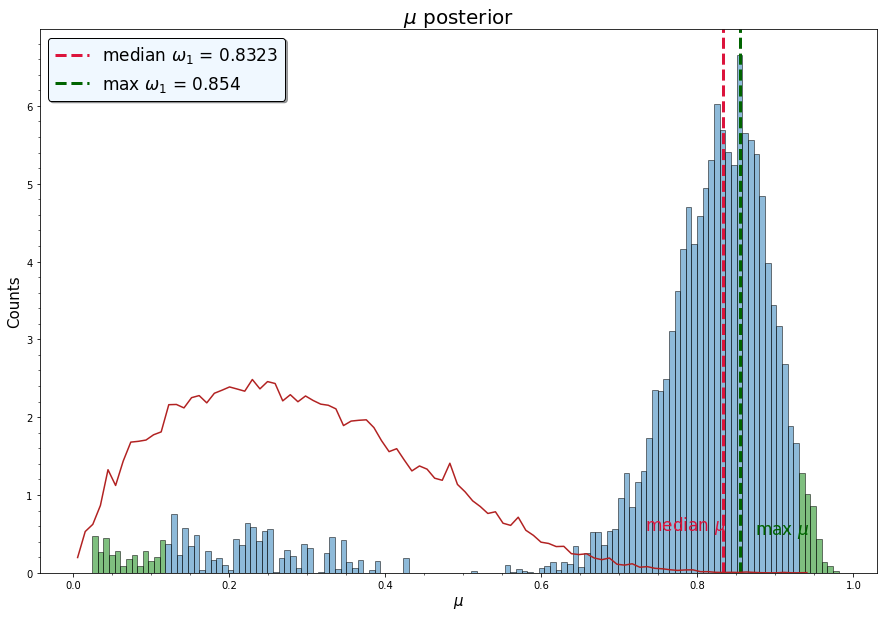

In [65]:
fig, ax, _, _ = plot_func_real(chain= chain_start_real, parameter = 'mu', y_max=0.5, y_median=0.55)
ax.plot(centers_mu_s_r, counts_mu_s_r, color='firebrick')

Median value of omega_1: 0.2858
Max value of omega_1: 0.2668


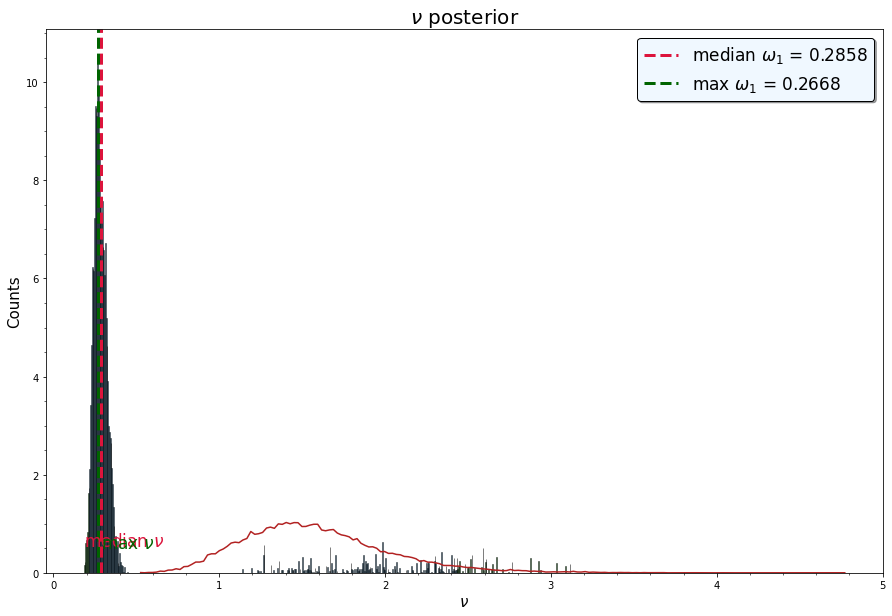

In [66]:
fig, ax, _, _ = plot_func_real(chain= chain_start_real, parameter = 'nu', y_max=0.5, y_median=0.55)
ax.plot(centers_nu_s_r, counts_nu_s_r, color='firebrick')

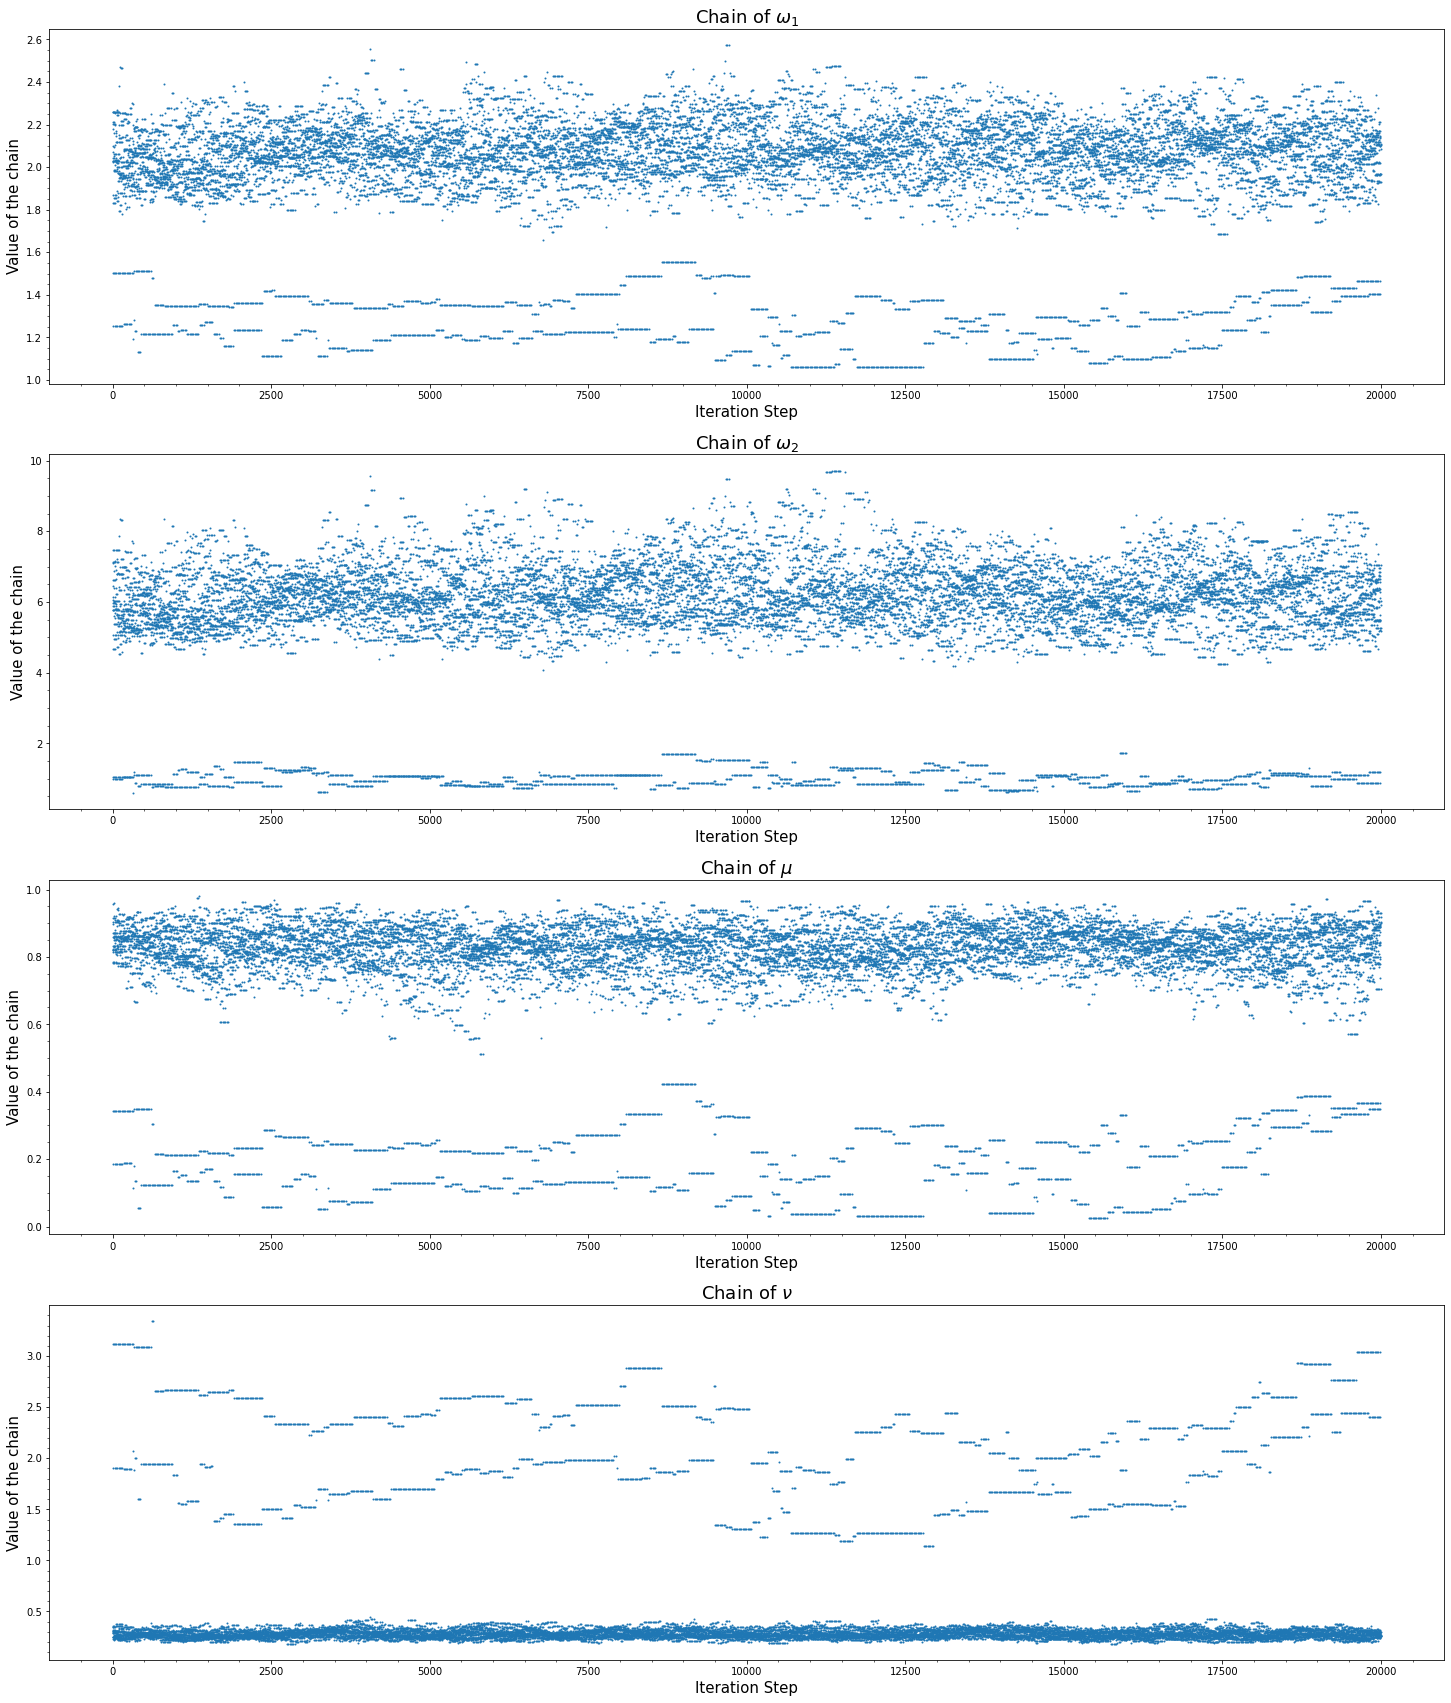

In [67]:
fig, ax = chains_plot(chain_start_real)

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: Th

(0.0, 1.0)

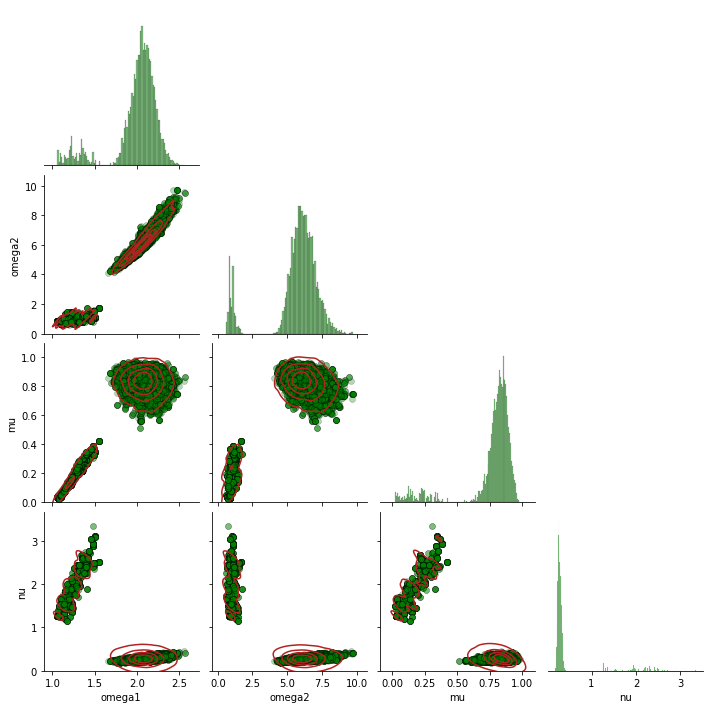

In [68]:
chain_df = pd.DataFrame(chain_start_real, columns=['omega1', 'omega2', 'mu', 'nu'])
g = sns.pairplot(chain_df, diag_kind="hist", corner=True, plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.3}, diag_kws={'color':'green', 'alpha':0.5})
g.map_lower(sns.kdeplot, levels=5, color="firebrick", linewidth=2)
axes = g.axes.ravel()
axes_2 = []
for ax in axes:
    if ax != None:
        axes_2.append(ax)
axes_2

axes_2[2].set_ylim(bottom=0)
axes_2[4].set_ylim(bottom=0)
axes_2[6].set_ylim(bottom=0)
axes_2[0].set_ylim(bottom=0)



In [69]:


sampler = emcee.EnsembleSampler(n_walkers, 4, j_log_unnorm_posterior_emcee, kwargs={'y_times': df_microbial_growth['generationtime'], 'PDF':PDF_mod2}, a=2)
'''
3   is the number of dimensions in the parameter space
a=2 is the proposal scale parameter. (default: 2.0)
'''

pos, prob, state = sampler.run_mcmc(p0, 500)
sampler.reset()
sampler.run_mcmc(pos, 1000, rstate0=state)

chain_mod2_real = sampler.get_chain(flat=True)


  lnpdiff = f + nlp - state.log_prob[j]
/root/venv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/root/venv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/root/venv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/root/venv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/root/venv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/root/venv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalar

Median value of omega_1: 1.3627
Max value of omega_1: 1.4076


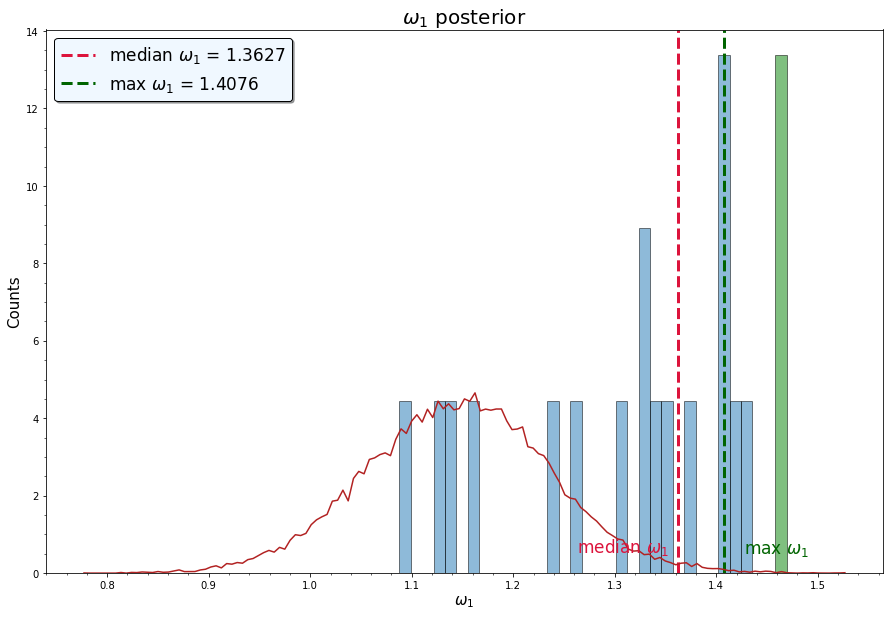

In [70]:
fig, ax, _, _ = plot_func_real(chain= chain_mod2_real, parameter = 'omega_1', y_max=0.5, y_median=0.55)
ax.plot(centers_omega1_s_r, counts_omega1_s_r, color='firebrick')

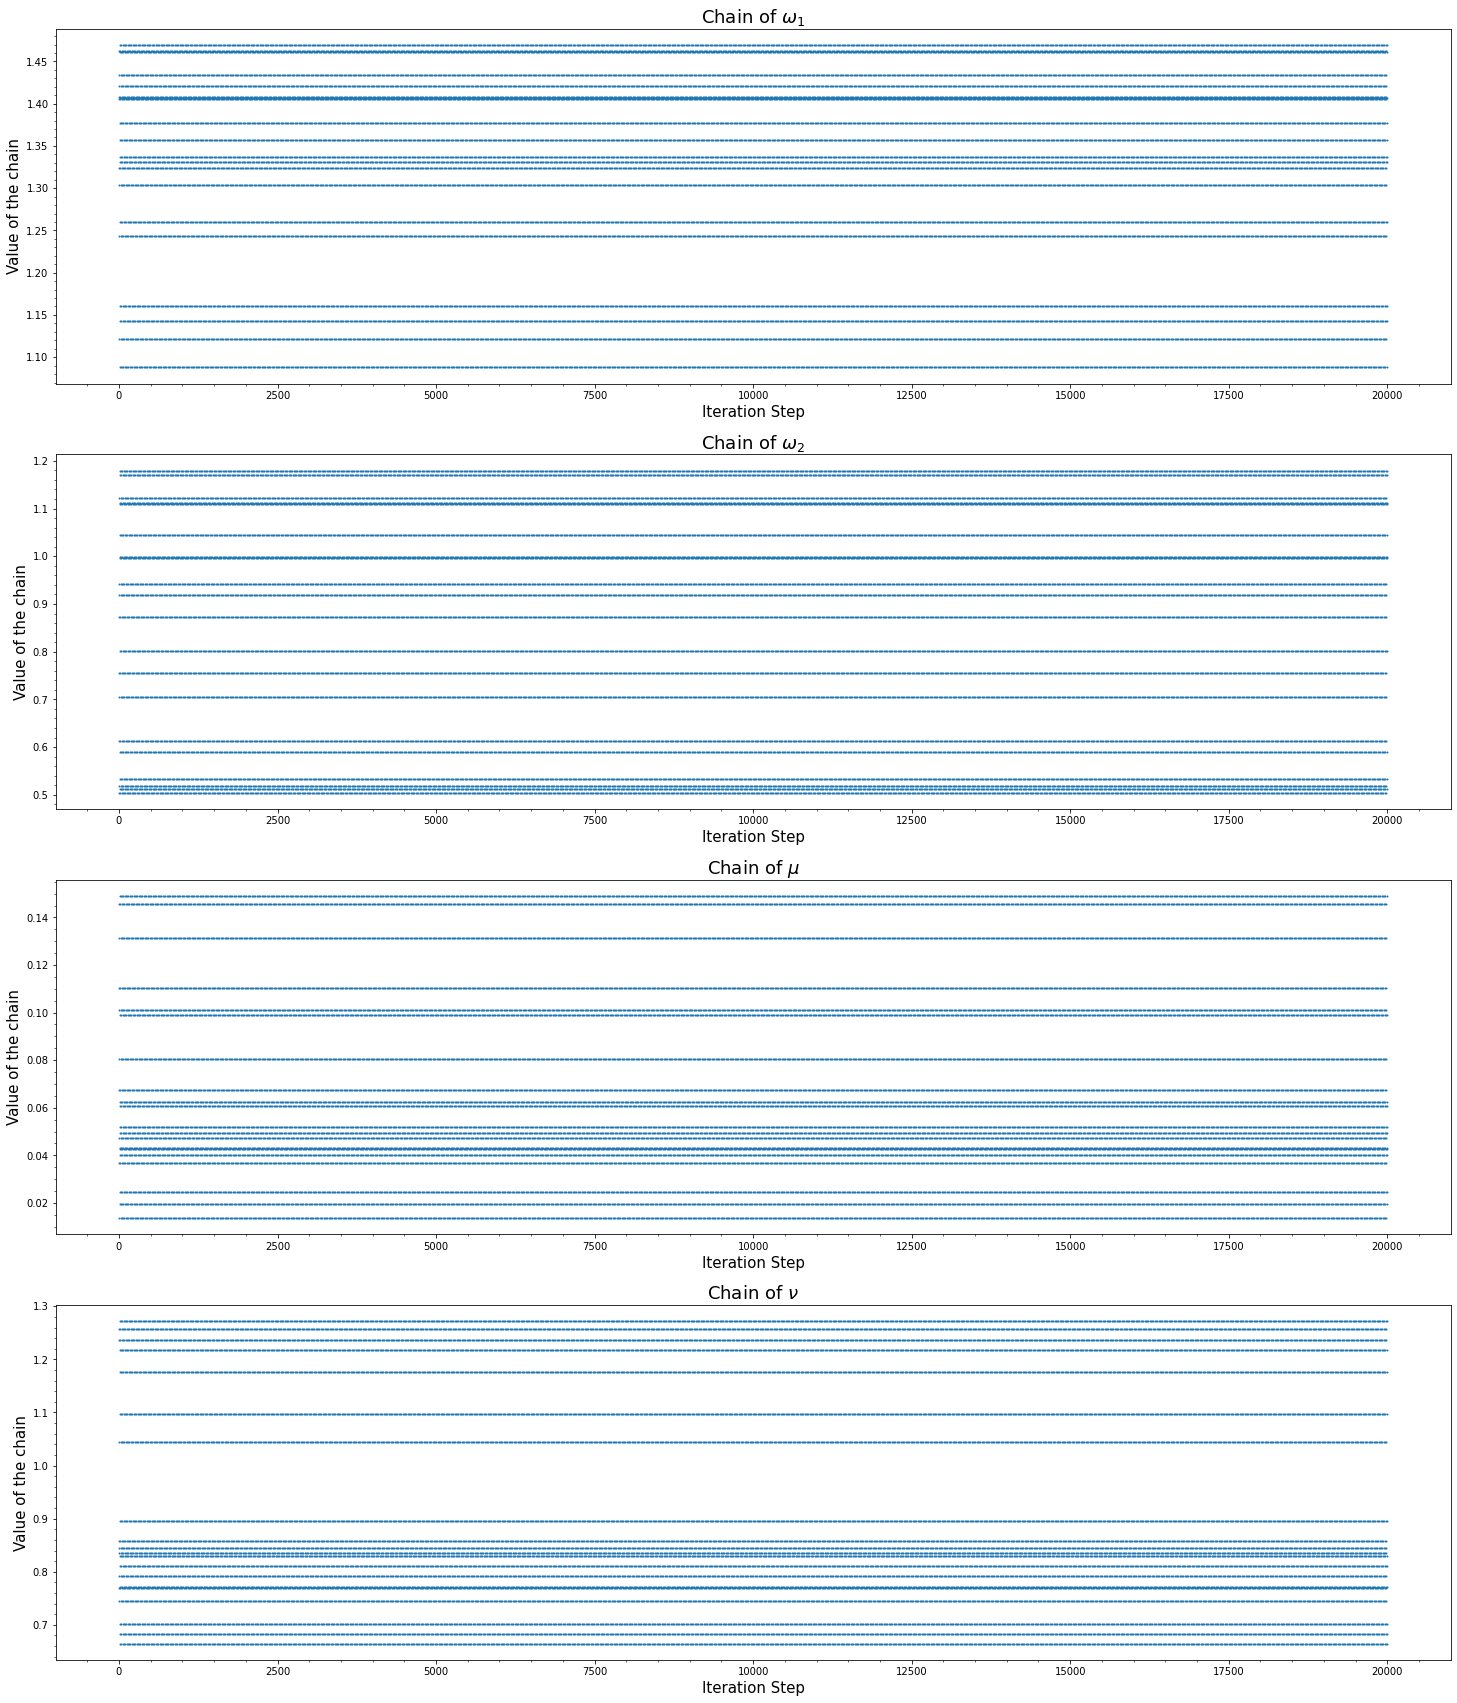

In [71]:
fig, ax = chains_plot(chain_mod2_real)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52dba48d-3798-4665-95fc-01a96804955b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>